1. Preprocessing Routine
Objective: Implement a preprocessing pipeline to clean and standardize data, ensuring that both training and test data are processed the same way.
Implementation: Use tools like StandardScaler for normalization and SimpleImputer for handling missing values. Package this as a pipeline step in sklearn to maintain consistency across different stages.
2. Feature Selection and Dimensionality Reduction
Objective: Prioritize the most relevant features and potentially reduce the feature space for faster training.

Approach:

Permutation Testing: Test different feature subsets by dropping specific columns and evaluating changes in performance. Track changes in the F1 score for each subset to identify impactful features.
Dimensionality Reduction (PCA): Use PCA to further reduce dimensionality by retaining components that account for a significant portion of variance (e.g., 95%). This can accelerate model training by reducing noise and unimportant features.
Feature Importance from PCA: Evaluate which features contribute most to each principal component, based on eigenvalues. Discard features with minimal contributions to maintain a balance between performance and model complexity.

3. Model Training with XGBoost Classifier
Objective: Train the model using the optimized feature set from the previous step.
Pipeline Setup: Create a pipeline that includes the preprocessing, feature selection, and XGBoost model.
Hyperparameter Tuning with K-Fold Grid Search:
Use GridSearchCV to tune hyperparameters such as learning_rate, max_depth, n_estimators, and subsample.
Set scoring='f1' to prioritize the F1 score during optimization.
4. Evaluate the Impact of Feature Selection and Dimensionality Reduction
Objective: Determine whether feature reduction has improved, degraded, or maintained model performance.
Comparison: After finding the optimal hyperparameters, compare F1 scores from models trained with full features versus reduced features (via permutation tests and PCA) to confirm the benefits of feature selection.
5. Latent Space Embedding Projection (Optional)
Objective: Further understand the data structure by projecting it into a latent space for analysis.
Techniques: Use t-SNE, UMAP, or autoencoders to create embeddings that could reveal additional patterns or relationships, potentially informing new feature engineering strategies.
6. Neural Network Exploration (Optional)
Objective: Explore neural networks as an alternative to XGBoost for this task.
Implementation:
Replace XGBoost with a neural network architecture, varying parameters like layer count, activation functions, learning rate, and batch size.
Use GridSearchCV for tuning and evaluation, focusing on the F1 score to match previous results.
Comparison: Evaluate neural network performance relative to XGBoost in terms of F1 score and computational efficiency.


In [36]:
!pip install category-encoders==2.6.2

In [87]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# next step could be to take the preprocessing from the first notebook to this one

test_clean_df = pd.read_csv('cleaned_test_dataset.csv')
train_clean_df = pd.read_csv('cleaned_dataset.csv')

<ipython-input-87-bbc0c738b47b>:11: DtypeWarning: Columns (29,50) have mixed types. Specify dtype option on import or set low_memory=False.
  train_clean_df = pd.read_csv('cleaned_dataset.csv')


In [38]:
train_clean_df

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents,Accident Date_Month,Accident Date_Quarter,Accident Date_Year,Assembly Date_Month,Assembly Date_Quarter,Assembly Date_Year,C-2 Date_Month,C-2 Date_Quarter,C-2 Date_Year,C-3 Date_Month,C-3 Date_Quarter,C-3 Date_Year,First Hearing Date_Month,First Hearing Date_Quarter,First Hearing Date_Year,Carrier_Category,County_Grouped,Zip_Region,Industry_Grouped,WCIO Cause of Injury Description_Grouped,WCIO Nature of Injury Description_Grouped,WCIO Part Of Body Description_Grouped,Gender_Clean,ADR_Clean
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0,2019-12,2019Q4,2019.0,2020-01,2020Q1,2020,2019-12,2019Q4,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NEW HAMPSHIRE INSURANCE CO,OTHER_COUNTIES,136,RETAIL TRADE,FROM LIQUID OR GREASE SPILLS,CONTUSION,OTHER_Body,M,N
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0,2019-08,2019Q3,2019.0,2020-01,2020Q1,2020,2020-01,2020Q1,2020.0,2020-01,2020Q1,2020.0,2020-02,2020Q1,2020.0,OTHER_CARRIERS,OTHER_COUNTIES,145,CONSTRUCTION,REPETITIVE MOTION,SPRAIN OR TEAR,SHOULDER(S),F,N
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0,2019-12,2019Q4,2019.0,2020-01,2020Q1,2020,2020-01,2020Q1,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,INDEMNITY INSURANCE CO OF,ORANGE,125,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,OBJECT BEING LIFTED OR HANDLED,OTHER_Injury,MULTIPLE HEAD INJURY,M,N
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01,2020Q1,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OTHER_CARRIERS,OTHER_COUNTIES,NaN,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,NaN,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0,2019-12,2019Q4,2019.0,2020-01,2020Q1,2020,2019-12,2019Q4,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,STATE INSURANCE FUND,DUTCHESS,126,HEALTH CARE AND SOCIAL ASSISTANCE,"HAND TOOL, UTENSIL; NOT POWERED",PUNCTURE,FINGER(S),M,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327160035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12,2022Q4,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OTHER_CARRIERS,OTHER_COUNTIES,NaN,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,NaN,NaN
593467,

In [39]:
train_clean_df.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'OIICS Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents',
       'Accident Date_Month', 'Accident Date_Quarter', 'Accident Date_Year',
       'Assembly Date_Month', 'Assembly Date_Quarter', 'Assembly Date_Year',
       'C-2 Date_Month', 'C-2 Date_Quarter', 'C

In [40]:
missing_percentage = (train_clean_df.isnull().sum() / len(train_clean_df)) * 100

print(missing_percentage)

Accident Date                                  3.898084
Age at Injury                                  4.282265
Alternative Dispute Resolution                 3.276487
Assembly Date                                  0.000000
Attorney/Representative                        3.276487
Average Weekly Wage                            8.104187
Birth Year                                    12.432789
C-2 Date                                       5.729850
C-3 Date                                      68.449174
Carrier Name                                   3.276487
Carrier Type                                   3.276487
Claim Identifier                               0.000000
Claim Injury Type                              3.276487
County of Injury                               3.276487
COVID-19 Indicator                             3.276487
District Name                                  3.276487
First Hearing Date                            74.590502
Gender                                         3

In [88]:
# exclude colls definition
exclude_cols = [
    'Zip Code',
    'OIICS Nature of Injury Description',
    'IME-4 Count',
    'First Hearing Date_Year',
    'First Hearing Date_Quarter',
    'First Hearing Date_Month',
    'First Hearing Date',
    'C-3 Date_Year',
    'C-3 Date',
    'C-3 Date_Quarter',
    'C-3 Date_Month',
    'Alternative Dispute Resolution',
    'WCIO Nature of Injury Code',
    'WCIO Nature of Injury Description',
    'Gender',
    'WCIO Cause of Injury Description',
    'Industry Code Description',
    'County of Injury',
    'Carrier Name',
    'Accident Date_Month',	'Accident Date_Quarter',	'Accident Date_Year' ,	'Assembly Date_Month',	'Assembly Date_Quarter'	,'Assembly Date_Year',	'C-2 Date_Month',	'C-2 Date_Quarter',	'C-2 Date_Year'
]

#claim injury identifier before testing, and agreement reached



In [89]:
numerical_features = train_clean_df.select_dtypes(include=np.number).columns
categorical_features = train_clean_df.select_dtypes(exclude=np.number).columns

for feature in numerical_features:
   train_clean_df[feature] = train_clean_df[feature].fillna(train_clean_df[feature].mean())

for feature in categorical_features:
   train_clean_df[feature] = train_clean_df[feature].fillna(train_clean_df[feature].mode()[0])

In [90]:
train_dropped_df = train_clean_df.copy()

columns_to_drop = exclude_cols

train_dropped_df = train_dropped_df.drop(columns=columns_to_drop)

test_dropped_df = test_clean_df.copy()
test_dropped_df = test_dropped_df.drop(columns=columns_to_drop)



In [91]:
train_clean_df

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents,Accident Date_Month,Accident Date_Quarter,Accident Date_Year,Assembly Date_Month,Assembly Date_Quarter,Assembly Date_Year,C-2 Date_Month,C-2 Date_Quarter,C-2 Date_Year,C-3 Date_Month,C-3 Date_Quarter,C-3 Date_Year,First Hearing Date_Month,First Hearing Date_Quarter,First Hearing Date_Year,Carrier_Category,County_Grouped,Zip_Region,Industry_Grouped,WCIO Cause of Injury Description_Grouped,WCIO Nature of Injury Description_Grouped,WCIO Part Of Body Description_Grouped,Gender_Clean,ADR_Clean
0,2019-12-30,31.00000,N,2020-01-01,N,0.000000,1988.000000,2019-12-31,2021-04-21,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,2022-04-15,M,3.110657,44.000000,RETAIL TRADE,I,NaN,27.000000,FROM LIQUID OR GREASE SPILLS,10.000000,CONTUSION,62.000000,BUTTOCKS,13662,0.000000,Not Work Related,1.000000,2019-12,2019Q4,2019.000000,2020-01,2020Q1,2020,2019-12,2019Q4,2019.000000,2021-03,2021Q2,2021.075431,2023-03,2021Q4,2021.719552,NEW HAMPSHIRE INSURANCE CO,OTHER_COUNTIES,136,RETAIL TRADE,FROM LIQUID OR GREASE SPILLS,CONTUSION,OTHER_Body,M,N
1,2019-08-30,46.00000,N,2020-01-01,Y,1745.930000,1973.000000,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.000000,23.000000,CONSTRUCTION,I,NaN,97.000000,REPETITIVE MOTION,49.000000,SPRAIN OR TEAR,38.000000,SHOULDER(S),14569,1.000000,Not Work Related,4.000000,2019-08,2019Q3,2019.000000,2020-01,2020Q1,2020,2020-01,2020Q1,2020.000000,2020-01,2020Q1,2020.000000,2020-02,2020Q1,2020.000000,OTHER_CARRIERS,OTHER_COUNTIES,145,CONSTRUCTION,REPETITIVE MOTION,SPRAIN OR TEAR,SHOULDER(S),F,N
2,2019-12-06,40.00000,N,2020-01-01,N,1434.800000,1979.000000,2020-01-01,2021-04-21,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,2022-04-15,M,3.110657,56.000000,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.000000,OBJECT BEING LIFTED OR HANDLED,7.000000,CONCUSSION,10.000000,MULTIPLE HEAD INJURY,12589,0.000000,Not Work Related,6.000000,2019-12,2019Q4,2019.000000,2020-01,2020Q1,2020,2020-01,2020Q1,2020.000000,2021-03,2021Q2,2021.075431,2023-03,2021Q4,2021.719552,INDEMNITY INSURANCE CO OF,ORANGE,125,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,OBJECT BEING LIFTED OR HANDLED,OTHER_Injury,MULTIPLE HEAD INJURY,M,N
3,2020-03-01,42.50377,N,2020-01-01,N,491.088321,1977.815483,2021-05-11,2021-04-21,STATE INSURANCE FUND,1A. PRIVATE,957648180,2. NON-COMP,SUFFOLK,N,NYC,2022-04-15,M,3.110657,58.645305,HEALTH CARE AND SOCIAL ASSISTANCE,IV,NaN,54.381143,LIFTING,41.013839,STRAIN OR TEAR,43.714466,LOWER BACK AREA,11236,0.046665,Not Work Related,3.006559,2020-03,2020Q1,2020.827849,2020-01,2020Q1,2020,2022-08,2022Q3,2021.044907,2021-03,2021Q2,2021.075431,2023-03,2021Q4,2021.719552,OTHER_CARRIERS,OTHER_COUNTIES,117,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,M,N
4,2019-12-30,61.00000,N,2020-01-01,N,491.088321,1958.000000,2019-12-31,2021-04-21,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,2022-04-15,M,3.110657,62.000000,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.000000,"HAND TOOL, UTENSIL; NOT POWERED",43.000000,PUNCTURE,36.000000,FINGER(S),12603,0.000000,Not Work Related,1.000000,2019-12,2019Q4,2019.000000,2020-01,2020Q1,2020,2019-12,2019Q4,2019.000000,2021-03,2021Q2,2021.075431,2023-03,2021Q4,2021.719552,STATE INSURANCE FUND,DUTCHESS,126,HEALTH CARE AND SOCIAL ASS

In [92]:
test_clean_df

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents,Accident Date_Month,Accident Date_Quarter,Accident Date_Year,Assembly Date_Month,Assembly Date_Quarter,Assembly Date_Year,C-2 Date_Month,C-2 Date_Quarter,C-2 Date_Year,C-3 Date_Month,C-3 Date_Quarter,C-3 Date_Year,First Hearing Date_Month,First Hearing Date_Quarter,First Hearing Date_Year,Carrier_Category,County_Grouped,Zip_Region,Industry_Grouped,WCIO Cause of Injury Description_Grouped,WCIO Nature of Injury Description_Grouped,WCIO Part Of Body Description_Grouped,Gender_Clean,ADR_Clean
0,2022-12-24,19.0,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,6165911,BRONX,N,NYC,NaN,M,NaN,48.0,TRANSPORTATION AND WAREHOUSING,IV,NaN,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,54.0,LOWER LEG,10466,1.0,2022-12,2022Q4,2022.0,2023-01,2023Q1,2023.0,2023-01,2023Q1,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,INDEMNITY INSURANCE CO OF,BRONX,104,TRANSPORTATION AND WAREHOUSING,"FALL, SLIP OR TRIP, NOC",CONTUSION,LOWER LEG,M,N
1,2022-11-20,19.0,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,A I U INSURANCE COMPANY,1A. PRIVATE,6166141,QUEENS,N,NYC,NaN,F,NaN,45.0,RETAIL TRADE,IV,NaN,75.0,FALLING OR FLYING OBJECT,10.0,CONTUSION,10.0,MULTIPLE HEAD INJURY,11691,1.0,2022-11,2022Q4,2022.0,2023-01,2023Q1,2023.0,2023-01,2023Q1,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,A I U INSURANCE COMPANY,QUEENS,116,RETAIL TRADE,FALLING OR FLYING OBJECT,CONTUSION,MULTIPLE HEAD INJURY,F,N
2,2022-12-26,59.0,N,2023-01-02,N,0.0,1963.0,2022-12-31,NaN,AMGUARD INSURANCE COMPANY,1A. PRIVATE,6165907,WESTCHESTER,N,NYC,NaN,F,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,III,NaN,68.0,STATIONARY OBJECT,49.0,SPRAIN OR TEAR,62.0,BUTTOCKS,10604,0.0,2022-12,2022Q4,2022.0,2023-01,2023Q1,2023.0,2022-12,2022Q4,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,OTHER_CARRIERS,WESTCHESTER,106,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,STATIONARY OBJECT,SPRAIN OR TEAR,OTHER_Body,F,N
3,2022-12-28,55.0,N,2023-01-02,N,0.0,NaN,2023-01-02,NaN,INDEMNITY INS. OF N AMERICA,1A. PRIVATE,6166047,QUEENS,N,NYC,NaN,F,NaN,48.0,TRANSPORTATION AND WAREHOUSING,IV,NaN,25.0,FROM DIFFERENT LEVEL (ELEVATION),10.0,CONTUSION,53.0,KNEE,11411,6.0,2022-12,2022Q4,2022.0,2023-01,2023Q1,2023.0,2023-01,2023Q1,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,INDEMNITY INS. OF N AMERICA,QUEENS,114,TRANSPORTATION AND WAREHOUSING,FROM DIFFERENT LEVEL (ELEVATION),CONTUSION,KNEE,F,N
4,2022-12-20,25.0,N,2023-01-02,N,0.0,1997.0,2022-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,6166102,KINGS,N,NYC,NaN,M,NaN,55.0,MANAGEMENT OF COMPANIES AND ENTERPRISES,IV,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,40.0,LACERATION,37.0,THUMB,11212,5.0,2022-12,2022Q4,2022.0,2023-01,2023Q1,2023.0,2022-12,2022Q4,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,OTHER_CARRIERS,KINGS,112,OTHER_INDUSTRIES,OBJECT BEING LIFTED OR HANDLED,LACERATION,THUMB,M,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341910,2024-03-16,31.0,N,2024-04-03,N,0.0,1992.0,2024-04-03,2024-05-11,"MACY'S, INC.",4A. SELF PRIVATE,6508711,KINGS,N,NYC,NaN,F,NaN,45.0,RETAIL TRADE,IV,NaN,81.0,"STRUCK OR INJURED, NOC",59.0,"ALL OTHER SPECIFIC INJURIES, NOC",38.0,SHOULDER(S),11226,0.0,2024-03,2024Q1,2024.0,2024-04,2024Q2,2024.0,2024-04,2024Q2,2024.0,2024-05,2024Q2,2024.0,NaN,NaN,NaN,OTHER_CARRIERS,KINGS,112,RETAIL TRADE,"STRUCK OR INJURED, NOC","ALL OTHER SPECIFIC INJURIES, NOC",SHOULD

In [45]:
pd.set_option('display.max_columns', None)
train_dropped_df

,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,Carrier Type,Claim Identifier,Claim Injury Type,COVID-19 Indicator,District Name,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Part Of Body Code,WCIO Part Of Body Description,Agreement Reached,WCB Decision,Number of Dependents,Carrier_Category,County_Grouped,Zip_Region,Industry_Grouped,WCIO Cause of Injury Description_Grouped,WCIO Nature of Injury Description_Grouped,WCIO Part Of Body Description_Grouped,Gender_Clean,ADR_Clean
0,2019-12-30,31.00000,2020-01-01,N,0.000000,1988.000000,2019-12-31,1A. PRIVATE,5393875,2. NON-COMP,N,SYRACUSE,44.000000,I,27.000000,62.000000,BUTTOCKS,0.000000,Not Work Related,1.000000,NEW HAMPSHIRE INSURANCE CO,OTHER_COUNTIES,136,RETAIL TRADE,FROM LIQUID OR GREASE SPILLS,CONTUSION,OTHER_Body,M,N
1,2019-08-30,46.00000,2020-01-01,Y,1745.930000,1973.000000,2020-01-01,1A. PRIVATE,5393091,4. TEMPORARY,N,ROCHESTER,23.000000,I,97.000000,38.000000,SHOULDER(S),1.000000,Not Work Related,4.000000,OTHER_CARRIERS,OTHER_COUNTIES,145,CONSTRUCTION,REPETITIVE MOTION,SPRAIN OR TEAR,SHOULDER(S),F,N
2,2019-12-06,40.00000,2020-01-01,N,1434.800000,1979.000000,2020-01-01,1A. PRIVATE,5393889,4. TEMPORARY,N,ALBANY,56.000000,II,79.000000,10.000000,MULTIPLE HEAD INJURY,0.000000,Not Work Related,6.000000,INDEMNITY INSURANCE CO OF,ORANGE,125,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,OBJECT BEING LIFTED OR HANDLED,OTHER_Injury,MULTIPLE HEAD INJURY,M,N
3,2020-03-01,42.50377,2020-01-01,N,491.088321,1977.815483,2021-05-11,1A. PRIVATE,957648180,2. NON-COMP,N,NYC,58.645305,IV,54.381143,43.714466,LOWER BACK AREA,0.046665,Not Work Related,3.006559,OTHER_CARRIERS,OTHER_COUNTIES,117,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,M,N
4,2019-12-30,61.00000,2020-01-01,N,491.088321,1958.000000,2019-12-31,2A. SIF,5393887,2. NON-COMP,N,ALBANY,62.000000,II,16.000000,36.000000,FINGER(S),0.000000,Not Work Related,1.000000,STATE INSURANCE FUND,DUTCHESS,126,HEALTH CARE AND SOCIAL ASSISTANCE,"HAND TOOL, UTENSIL; NOT POWERED",PUNCTURE,FINGER(S),M,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,2020-03-01,42.50377,2022-12-31,N,491.088321,1977.815483,2021-05-11,1A. PRIVATE,327160035,2. NON-COMP,N,NYC,58.645305,IV,54.381143,43.714466,LOWER BACK AREA,0.046665,Not Work Related,3.006559,OTHER_CARRIERS,OTHER_COUNTIES,117,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,M,N
593467,2022-12-13,72.00000,2022-12-31,N,0.000000,1950.000000,2022-12-31,1A. PRIVATE,6165075,2. NON-COMP,N,BINGHAMTON,48.000000,I,25.000000,43.714466,MULTIPLE,0.000000,Not Work Related,3.000000,OTHER_CARRIERS,OTHER_COUNTIES,127,TRANSPORTATION AND WAREHOUSING,FROM DIFFERENT LEVEL (ELEVATION),MULTIPLE PHYSICAL INJURIES ONLY,MULTIPLE,F,N
593468,2020-03-01,42.50377,2022-12-31,N,491.088321,1977.815483,2021-05-11,1A. PRIVATE,249875936,2. NON-COMP,N,NYC,58.645305,IV,54.381143,43.714466,LOWER BACK AREA,0.046665,Not Work Related,3.006559,OTHER_CARRIERS,OTHER_COUNTIES,117,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,M,N
593469,2020-03-01,42.50377,2022-12-31,N,491.088321,1977.815483,2021-05-11,1A. PRIVATE,120584215,2. NON-COMP,N,NYC,58.645305,IV,54.381143,43.714466,LOWER BACK AREA,0.046665,Not Work Related,3.006559,OTHER_CARRIERS,OTHER_COUNTIES,117,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,M,N


In [93]:


for col in train_dropped_df.select_dtypes(include=['object', 'category']).columns:
    print(f"\n{col}:")
    print(train_dropped_df[col].value_counts(normalize=True).multiply(100).round(2))



for col in test_dropped_df.select_dtypes(include=['object', 'category']).columns:
    print(f"\n{col}:")
    print(test_dropped_df[col].value_counts(normalize=True).multiply(100).round(2))


Accident Date:
Accident Date
2020-03-01    4.11
2020-12-18    0.17
2022-02-07    0.16
2022-01-05    0.15
2021-02-18    0.14
              ... 
2017-05-17    0.00
2015-05-28    0.00
2002-08-18    0.00
2017-09-01    0.00
1980-05-17    0.00
Name: proportion, Length: 5539, dtype: float64

Assembly Date:
Assembly Date
2020-03-06    0.24
2021-05-11    0.23
2022-04-01    0.21
2022-02-04    0.21
2022-08-15    0.20
              ... 
2022-07-31    0.00
2021-12-19    0.00
2020-08-23    0.00
2020-07-04    0.00
2022-05-08    0.00
Name: proportion, Length: 1096, dtype: float64

Attorney/Representative:
Attorney/Representative
N    69.38
Y    30.62
Name: proportion, dtype: float64

C-2 Date:
C-2 Date
2021-05-11    6.04
2020-03-05    0.23
2021-05-27    0.21
2022-08-15    0.19
2021-06-22    0.18
              ... 
2006-06-26    0.00
1998-10-30    0.00
2004-03-03    0.00
2011-12-29    0.00
2024-01-19    0.00
Name: proportion, Length: 2475, dtype: float64

Carrier Type:
Carrier Type
1A. PRIVATE        

In [95]:
import pandas as pd
import numpy as np

def drop_grouped_columns(df):
    """
    Drop all columns that contain 'Grouped' or '_Grouped' in their names
    """
    grouped_cols = [col for col in df.columns if 'Grouped' in col or '_Grouped' in col]
    return df.drop(columns=grouped_cols)

def safe_bin(series, bins=10):
    """
    Safely bin a series using cut instead of qcut
    """
    clean_series = pd.to_numeric(series, errors='coerce')
    clean_series = clean_series.dropna()

    if len(clean_series) == 0:
        return pd.Series(index=series.index)

    min_val = clean_series.min()
    max_val = clean_series.max()

    if min_val == max_val:
        return pd.Series('Bin_1', index=series.index)

    bin_edges = np.linspace(min_val, max_val, bins + 1)
    labels = [f'Bin_{i+1}' for i in range(bins)]

    try:
        binned = pd.cut(clean_series,
                       bins=bin_edges,
                       labels=labels,
                       include_lowest=True)
        return binned
    except Exception as e:
        print(f"Binning error for values between {min_val} and {max_val}: {str(e)}")
        return series

def create_bins(df):
    """
    Create bins for numerical variables in the dataset
    """
    df_binned = df.copy()

    # Date variables binning
    date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date']
    for col in date_columns:
        try:
            dates = pd.to_datetime(df_binned[col], errors='coerce')
            timestamps = dates.astype(np.int64)
            df_binned[f'{col}_binned'] = safe_bin(timestamps)
        except Exception as e:
            print(f"Warning: Could not bin {col}: {str(e)}")

    # Numeric columns binning
    numeric_columns = [
        'Age at Injury',
        'Birth Year',
        'Average Weekly Wage',
        'Industry Code',
        'WCIO Cause of Injury Code',
        'WCIO Part Of Body Code',
        'Number of Dependents',
        'Agreement Reached'
    ]

    for col in numeric_columns:
        try:
            df_binned[f'{col}_binned'] = safe_bin(df_binned[col])
        except Exception as e:
            print(f"Warning: Could not bin {col}: {str(e)}")

    # Zip Region binning
    try:
        zip_values = pd.to_numeric(df_binned['Zip_Region'].astype(str).str.extract('(\d+)')[0],
                                 errors='coerce')
        df_binned['Zip_Region_binned'] = safe_bin(zip_values)
    except Exception as e:
        print(f"Warning: Could not bin Zip_Region: {str(e)}")

    return df_binned

def apply_binning(df):
    """
    Drop grouped columns and apply binning
    """
    # First drop grouped columns
    df_cleaned = drop_grouped_columns(df)

    # Then apply binning
    binned_df = create_bins(df_cleaned)

    # Create summary of binning results
    summary = {}
    binned_columns = [col for col in binned_df.columns if col.endswith('_binned')]

    for col in binned_columns:
        value_counts = binned_df[col].value_counts().sort_index()
        summary[col] = {
            'distribution': value_counts.to_dict(),
            'null_count': binned_df[col].isnull().sum(),
            'unique_values': len(value_counts)
        }

    return binned_df, summary

# Run the binning
binned_df, summary = apply_binning(train_dropped_df)

# Print dropped columns
original_cols = set(train_dropped_df.columns)
remaining_cols = set(binned_df.columns)
dropped_cols = original_cols - remaining_cols - {col for col in remaining_cols if col.endswith('_binned')}
print("\nDropped columns:")
for col in sorted(dropped_cols):
    print(f"- {col}")

# Print summary statistics
print("\nBinning Summary:")
for col, stats in summary.items():
    print(f"\n{col}:")
    print(f"Number of unique bins: {stats['unique_values']}")
    print(f"Number of null values: {stats['null_count']}")
    print("Distribution:")
    for bin_name, count in stats['distribution'].items():
        print(f"  {bin_name}: {count}")

# Print sample of binned data
print("\nSample of binned data:")
print(binned_df[[col for col in binned_df.columns if col.endswith('_binned')]].head())


Dropped columns:
- County_Grouped
- Industry_Grouped
- WCIO Cause of Injury Description_Grouped
- WCIO Nature of Injury Description_Grouped
- WCIO Part Of Body Description_Grouped

Binning Summary:

Accident Date_binned:
Number of unique bins: 10
Number of null values: 0
Distribution:
  Bin_1: 7
  Bin_2: 17
  Bin_3: 39
  Bin_4: 62
  Bin_5: 247
  Bin_6: 511
  Bin_7: 1242
  Bin_8: 1134
  Bin_9: 1826
  Bin_10: 588386

Assembly Date_binned:
Number of unique bins: 10
Number of null values: 0
Distribution:
  Bin_1: 57636
  Bin_2: 50351
  Bin_3: 55931
  Bin_4: 56396
  Bin_5: 61409
  Bin_6: 61761
  Bin_7: 58513
  Bin_8: 66115
  Bin_9: 62783
  Bin_10: 62576

C-2 Date_binned:
Number of unique bins: 10
Number of null values: 0
Distribution:
  Bin_1: 119
  Bin_2: 156
  Bin_3: 85
  Bin_4: 130
  Bin_5: 236
  Bin_6: 323
  Bin_7: 162
  Bin_8: 19
  Bin_9: 308296
  Bin_10: 283945

Age at Injury_binned:
Number of unique bins: 10
Number of null values: 0
Distribution:
  Bin_1: 36707
  Bin_2: 84616
  Bin_

In [98]:
import pandas as pd
import numpy as np

def drop_grouped_columns(df):
    """
    Drop all columns that contain 'Grouped' or '_Grouped' in their names
    """
    grouped_cols = [col for col in df.columns if 'Grouped' in col or '_Grouped' in col]
    return df.drop(columns=grouped_cols)

def safe_bin(series, bins=10):
    """
    Safely bin a series using cut instead of qcut
    """
    clean_series = pd.to_numeric(series, errors='coerce')
    clean_series = clean_series.dropna()

    if len(clean_series) == 0:
        return pd.Series(index=series.index)

    min_val = clean_series.min()
    max_val = clean_series.max()

    if min_val == max_val:
        return pd.Series('Bin_1', index=series.index)

    bin_edges = np.linspace(min_val, max_val, bins + 1)
    labels = [f'Bin_{i+1}' for i in range(bins)]

    try:
        binned = pd.cut(clean_series,
                       bins=bin_edges,
                       labels=labels,
                       include_lowest=True)
        return binned
    except Exception as e:
        print(f"Binning error for values between {min_val} and {max_val}: {str(e)}")
        return series

def create_bins(df):
    """
    Create bins for numerical variables in the dataset
    """
    df_binned = df.copy()

    # Date variables binning
    date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date']
    for col in date_columns:
        try:
            dates = pd.to_datetime(df_binned[col], errors='coerce')
            timestamps = dates.astype(np.int64)
            df_binned[f'{col}_binned'] = safe_bin(timestamps)
        except Exception as e:
            print(f"Warning: Could not bin {col}: {str(e)}")

    # Numeric columns binning
    numeric_columns = [
        'Age at Injury',
        'Birth Year',
        'Average Weekly Wage',
        'Industry Code',
        'WCIO Cause of Injury Code',
        'WCIO Part Of Body Code',
        'Number of Dependents',
        'Agreement Reached'
    ]

    for col in numeric_columns:
        try:
            df_binned[f'{col}_binned'] = safe_bin(df_binned[col])
        except Exception as e:
            print(f"Warning: Could not bin {col}: {str(e)}")

    # Zip Region binning
    try:
        zip_values = pd.to_numeric(df_binned['Zip_Region'].astype(str).str.extract('(\d+)')[0],
                                 errors='coerce')
        df_binned['Zip_Region_binned'] = safe_bin(zip_values)
    except Exception as e:
        print(f"Warning: Could not bin Zip_Region: {str(e)}")

    return df_binned

def apply_binning(df):
    """
    Drop grouped columns and apply binning
    """
    # First drop grouped columns
    df_cleaned = drop_grouped_columns(df)

    # Then apply binning
    binned_df = create_bins(df_cleaned)

    # Create summary of binning results
    summary = {}
    binned_columns = [col for col in binned_df.columns if col.endswith('_binned')]

    for col in binned_columns:
        value_counts = binned_df[col].value_counts().sort_index()
        summary[col] = {
            'distribution': value_counts.to_dict(),
            'null_count': binned_df[col].isnull().sum(),
            'unique_values': len(value_counts)
        }

    return binned_df, summary

# Run the binning
binned_df, summary = apply_binning(test_dropped_df)

# Print dropped columns
original_cols = set(test_dropped_df.columns)
remaining_cols = set(binned_df.columns)
dropped_cols = original_cols - remaining_cols - {col for col in remaining_cols if col.endswith('_binned')}
print("\nDropped columns:")
for col in sorted(dropped_cols):
    print(f"- {col}")

# Print summary statistics
print("\nBinning Summary:")
for col, stats in summary.items():
    print(f"\n{col}:")
    print(f"Number of unique bins: {stats['unique_values']}")
    print(f"Number of null values: {stats['null_count']}")
    print("Distribution:")
    for bin_name, count in stats['distribution'].items():
        print(f"  {bin_name}: {count}")

# Print sample of binned data
print("\nSample of binned data:")
print(binned_df[[col for col in binned_df.columns if col.endswith('_binned')]].head())


Dropped columns:
- County_Grouped
- Industry_Grouped
- WCIO Cause of Injury Description_Grouped
- WCIO Nature of Injury Description_Grouped
- WCIO Part Of Body Description_Grouped

Binning Summary:

Accident Date_binned:
Number of unique bins: 10
Number of null values: 0
Distribution:
  Bin_1: 2102
  Bin_2: 0
  Bin_3: 0
  Bin_4: 0
  Bin_5: 0
  Bin_6: 0
  Bin_7: 0
  Bin_8: 0
  Bin_9: 60
  Bin_10: 339753

Assembly Date_binned:
Number of unique bins: 10
Number of null values: 0
Distribution:
  Bin_1: 35076
  Bin_2: 35020
  Bin_3: 35016
  Bin_4: 32385
  Bin_5: 35651
  Bin_6: 34426
  Bin_7: 35933
  Bin_8: 29422
  Bin_9: 35305
  Bin_10: 33681

C-2 Date_binned:
Number of unique bins: 10
Number of null values: 0
Distribution:
  Bin_1: 6975
  Bin_2: 0
  Bin_3: 0
  Bin_4: 0
  Bin_5: 0
  Bin_6: 0
  Bin_7: 0
  Bin_8: 0
  Bin_9: 1
  Bin_10: 334939

Age at Injury_binned:
Number of unique bins: 10
Number of null values: 3440
Distribution:
  Bin_1: 24585
  Bin_2: 56210
  Bin_3: 58340
  Bin_4: 50405
 

In [108]:
binned_only_df

,Accident Date_binned,Assembly Date_binned,C-2 Date_binned,Age at Injury_binned,Birth Year_binned,Average Weekly Wage_binned,Industry Code_binned,WCIO Cause of Injury Code_binned,WCIO Part Of Body Code_binned,Number of Dependents_binned,Agreement Reached_binned,Zip_Region_binned
0,Bin_10,Bin_1,Bin_9,Bin_3,Bin_8,Bin_1,Bin_5,Bin_3,Bin_6,Bin_2,Bin_1,Bin_2
1,Bin_10,Bin_1,Bin_9,Bin_5,Bin_6,Bin_1,Bin_2,Bin_10,Bin_4,Bin_7,Bin_10,Bin_2
2,Bin_10,Bin_1,Bin_9,Bin_4,Bin_7,Bin_1,Bin_6,Bin_8,Bin_1,Bin_10,Bin_1,Bin_2
3,Bin_10,Bin_1,Bin_9,Bin_4,Bin_7,Bin_1,Bin_6,Bin_6,Bin_4,Bin_6,Bin_1,Bin_2
4,Bin_10,Bin_1,Bin_9,Bin_7,Bin_5,Bin_1,Bin_7,Bin_2,Bin_3,Bin_2,Bin_1,Bin_2
...,...,...,...,...,...,...,...,...,...,...,...,...
593466,Bin_10,Bin_10,Bin_9,Bin_4,Bin_7,Bin_1,Bin_6,Bin_6,Bin_4,Bin_6,Bin_1,Bin_2
593467,Bin_10,Bin_10,Bin_10,Bin_9,Bin_4,Bin_1,Bin_5,Bin_3,Bin_4,Bin_5,Bin_1,Bin_2
593468,Bin_10,Bin_10,Bin_9,Bin_4,Bin_7,Bin_1,Bin_6,Bin_6,Bin_4,Bin_6,Bin_1,Bin_2
593469,Bin_10,Bin_10,Bin_9,Bin_4,Bin_7,Bin_1,Bin_6,Bin_6,Bin_4,Bin_6,Bin_1,Bin_2


In [107]:
binned_df

,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,Carrier Type,Claim Identifier,COVID-19 Indicator,District Name,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Part Of Body Code,WCIO Part Of Body Description,Number of Dependents,Carrier_Category,Zip_Region,Gender_Clean,ADR_Clean,Accident Date_binned,Assembly Date_binned,C-2 Date_binned,Age at Injury_binned,Birth Year_binned,Average Weekly Wage_binned,Industry Code_binned,WCIO Cause of Injury Code_binned,WCIO Part Of Body Code_binned,Number of Dependents_binned,Zip_Region_binned
0,2022-12-24,19.0,2023-01-02,N,NaN,2003.0,2023-01-02,1A. PRIVATE,6165911,N,NYC,48.0,IV,31.0,54.0,LOWER LEG,1.0,INDEMNITY INSURANCE CO OF,104,M,N,Bin_10,Bin_1,Bin_10,Bin_1,Bin_10,NaN,Bin_5,Bin_4,Bin_5,Bin_2,Bin_2
1,2022-11-20,19.0,2023-01-02,N,NaN,2003.0,2023-01-02,1A. PRIVATE,6166141,N,NYC,45.0,IV,75.0,10.0,MULTIPLE HEAD INJURY,1.0,A I U INSURANCE COMPANY,116,F,N,Bin_10,Bin_1,Bin_10,Bin_1,Bin_10,NaN,Bin_5,Bin_8,Bin_1,Bin_2,Bin_2
2,2022-12-26,59.0,2023-01-02,N,0.0,1963.0,2022-12-31,1A. PRIVATE,6165907,N,NYC,56.0,III,68.0,62.0,BUTTOCKS,0.0,OTHER_CARRIERS,106,F,N,Bin_10,Bin_1,Bin_10,Bin_7,Bin_5,Bin_1,Bin_6,Bin_7,Bin_6,Bin_1,Bin_2
3,2022-12-28,55.0,2023-01-02,N,0.0,NaN,2023-01-02,1A. PRIVATE,6166047,N,NYC,48.0,IV,25.0,53.0,KNEE,6.0,INDEMNITY INS. OF N AMERICA,114,F,N,Bin_10,Bin_1,Bin_10,Bin_6,NaN,Bin_1,Bin_5,Bin_3,Bin_5,Bin_10,Bin_2
4,2022-12-20,25.0,2023-01-02,N,0.0,1997.0,2022-12-31,1A. PRIVATE,6166102,N,NYC,55.0,IV,79.0,37.0,THUMB,5.0,OTHER_CARRIERS,112,M,N,Bin_10,Bin_1,Bin_10,Bin_2,Bin_9,Bin_1,Bin_6,Bin_8,Bin_4,Bin_9,Bin_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341910,2024-03-16,31.0,2024-04-03,N,0.0,1992.0,2024-04-03,4A. SELF PRIVATE,6508711,N,NYC,45.0,IV,81.0,38.0,SHOULDER(S),0.0,OTHER_CARRIERS,112,F,N,Bin_10,Bin_10,Bin_10,Bin_3,Bin_9,Bin_1,Bin_5,Bin_9,Bin_4,Bin_1,Bin_2
341911,2024-02-20,59.0,2024-04-03,Y,0.0,1965.0,2024-04-02,1A. PRIVATE,6508052,N,BUFFALO,55.0,II,58.0,38.0,SHOULDER(S),3.0,OTHER_CARRIERS,142,M,N,Bin_10,Bin_10,Bin_10,Bin_7,Bin_5,Bin_1,Bin_6,Bin_6,Bin_4,Bin_5,Bin_2
341912,2024-02-02,36.0,2024-04-03,N,NaN,1987.0,2024-04-03,2A. SIF,6508310,N,ALBANY,92.0,I,74.0,31.0,UPPER ARM,4.0,STATE INSURANCE FUND,121,M,N,Bin_10,Bin_10,Bin_10,Bin_3,Bin_8,NaN,Bin_10,Bin_8,Bin_3,Bin_7,Bin_2
341913,2024-03-28,38.0,2024-04-03,N,0.0,1985.0,2024-04-03,1A. PRIVATE,6508160,N,ALBANY,42.0,I,57.0,42.0,LOWER BACK AREA,2.0,HARTFORD ACCIDENT & INDEMNITY,121,M,N,Bin_10,Bin_10,Bin_10,Bin_4,Bin_8,Bin_1,Bin_4,Bin_6,Bin_4,Bin_4,Bin_2


In [113]:
# Create a new DataFrame called 'modified_df'
modified_df = train_dropped_df[[col for col in train_dropped_df.columns if not col.endswith('_Grouped')]]

# Add columns from binned_only_df to 'modified_df'
modified_df = pd.concat([modified_df, binned_only_df], axis=1)

# Create a new DataFrame called 'modified_test_df'
modified_test_df = test_dropped_df[[col for col in test_dropped_df.columns if not col.endswith('_Grouped')]]

# Add columns from binned_df to 'modified_test_df'
modified_test_df = pd.concat([modified_test_df, binned_df], axis=1)

In [114]:
modified_test_df

,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,Carrier Type,Claim Identifier,COVID-19 Indicator,District Name,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Part Of Body Code,WCIO Part Of Body Description,Number of Dependents,Carrier_Category,Zip_Region,Gender_Clean,ADR_Clean,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,Carrier Type,Claim Identifier,COVID-19 Indicator,District Name,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Part Of Body Code,WCIO Part Of Body Description,Number of Dependents,Carrier_Category,Zip_Region,Gender_Clean,ADR_Clean,Accident Date_binned,Assembly Date_binned,C-2 Date_binned,Age at Injury_binned,Birth Year_binned,Average Weekly Wage_binned,Industry Code_binned,WCIO Cause of Injury Code_binned,WCIO Part Of Body Code_binned,Number of Dependents_binned,Zip_Region_binned
0,2022-12-24,19.0,2023-01-02,N,NaN,2003.0,2023-01-02,1A. PRIVATE,6165911,N,NYC,48.0,IV,31.0,54.0,LOWER LEG,1.0,INDEMNITY INSURANCE CO OF,104,M,N,2022-12-24,19.0,2023-01-02,N,NaN,2003.0,2023-01-02,1A. PRIVATE,6165911,N,NYC,48.0,IV,31.0,54.0,LOWER LEG,1.0,INDEMNITY INSURANCE CO OF,104,M,N,Bin_10,Bin_1,Bin_10,Bin_1,Bin_10,NaN,Bin_5,Bin_4,Bin_5,Bin_2,Bin_2
1,2022-11-20,19.0,2023-01-02,N,NaN,2003.0,2023-01-02,1A. PRIVATE,6166141,N,NYC,45.0,IV,75.0,10.0,MULTIPLE HEAD INJURY,1.0,A I U INSURANCE COMPANY,116,F,N,2022-11-20,19.0,2023-01-02,N,NaN,2003.0,2023-01-02,1A. PRIVATE,6166141,N,NYC,45.0,IV,75.0,10.0,MULTIPLE HEAD INJURY,1.0,A I U INSURANCE COMPANY,116,F,N,Bin_10,Bin_1,Bin_10,Bin_1,Bin_10,NaN,Bin_5,Bin_8,Bin_1,Bin_2,Bin_2
2,2022-12-26,59.0,2023-01-02,N,0.0,1963.0,2022-12-31,1A. PRIVATE,6165907,N,NYC,56.0,III,68.0,62.0,BUTTOCKS,0.0,OTHER_CARRIERS,106,F,N,2022-12-26,59.0,2023-01-02,N,0.0,1963.0,2022-12-31,1A. PRIVATE,6165907,N,NYC,56.0,III,68.0,62.0,BUTTOCKS,0.0,OTHER_CARRIERS,106,F,N,Bin_10,Bin_1,Bin_10,Bin_7,Bin_5,Bin_1,Bin_6,Bin_7,Bin_6,Bin_1,Bin_2
3,2022-12-28,55.0,2023-01-02,N,0.0,NaN,2023-01-02,1A. PRIVATE,6166047,N,NYC,48.0,IV,25.0,53.0,KNEE,6.0,INDEMNITY INS. OF N AMERICA,114,F,N,2022-12-28,55.0,2023-01-02,N,0.0,NaN,2023-01-02,1A. PRIVATE,6166047,N,NYC,48.0,IV,25.0,53.0,KNEE,6.0,INDEMNITY INS. OF N AMERICA,114,F,N,Bin_10,Bin_1,Bin_10,Bin_6,NaN,Bin_1,Bin_5,Bin_3,Bin_5,Bin_10,Bin_2
4,2022-12-20,25.0,2023-01-02,N,0.0,1997.0,2022-12-31,1A. PRIVATE,6166102,N,NYC,55.0,IV,79.0,37.0,THUMB,5.0,OTHER_CARRIERS,112,M,N,2022-12-20,25.0,2023-01-02,N,0.0,1997.0,2022-12-31,1A. PRIVATE,6166102,N,NYC,55.0,IV,79.0,37.0,THUMB,5.0,OTHER_CARRIERS,112,M,N,Bin_10,Bin_1,Bin_10,Bin_2,Bin_9,Bin_1,Bin_6,Bin_8,Bin_4,Bin_9,Bin_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341910,2024-03-16,31.0,2024-04-03,N,0.0,1992.0,2024-04-03,4A. SELF PRIVATE,6508711,N,NYC,45.0,IV,81.0,38.0,SHOULDER(S),0.0,OTHER_CARRIERS,112,F,N,2024-03-16,31.0,2024-04-03,N,0.0,1992.0,2024-04-03,4A. SELF PRIVATE,6508711,N,NYC,45.0,IV,81.0,38.0,SHOULDER(S),0.0,OTHER_CARRIERS,112,F,N,Bin_10,Bin_10,Bin_10,Bin_3,Bin_9,Bin_1,Bin_5,Bin_9,Bin_4,Bin_1,Bin_2
341911,2024-02-20,59.0,2024-04-03,Y,0.0,1965.0,2024-04-02,1A. PRIVATE,6508052,N,BUFFALO,55.0,II,58.0,38.0,SHOULDER(S),3.0,OTHER_CARRIERS,142,M,N,2024-02-20,59.0,2024-04-03,Y,0.0,1965.0,2024-04-02,1A. PRIVATE,6508052,N,BUFFALO,55.0,II,58.0,38.0,SHOULDER(S),3.0,OTHER_CARRIERS,142,M,N,Bin_10,Bin_10,Bin_10,Bin_7,Bin_5,Bin_1,Bin_6,Bin_6,Bin_4,Bin_5,Bin_2
341912,2024-02-02,36.0,2024-04-03,N,NaN,1987.0,2024-04-03,2A. SIF,6508310,N,ALBANY,92.0,I,74.0,31.0,UPPER ARM,4.0,STATE INSURANCE FUND,121,M,N,2024-02-02,36.0,2024-04-03,N,NaN,1987.0,2024-04-03,2A. SIF,6508310,N,ALBANY,92.0,I,74.0,31.0,UPPER ARM,4.0,STATE INSURANCE FUND,121,M,N,Bin_10,Bin_10,Bin_10,Bin_3,Bin_8,NaN,Bin_10,Bin_8,Bin_3,Bin_7,Bin_2
341913,2024-03-28,38.0,2024-04-03,N,0.0

In [115]:
import pandas as pd
import numpy as np

def bin_categorical(series):
    """
    Bin categorical variables into 5 roughly equal-sized groups based on cumulative proportions
    """
    # Get value counts and calculate cumulative proportions
    value_counts = series.value_counts(normalize=True).cumsum()
    bin_edges = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    bin_labels = ['Cat_Bin_1', 'Cat_Bin_2', 'Cat_Bin_3', 'Cat_Bin_4', 'Cat_Bin_5']

    # Create mapping dictionary for original values to bins
    bin_mapping = {}
    for value, cum_prop in value_counts.items():
        for i, (edge1, edge2) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
            if cum_prop <= edge2:
                bin_mapping[value] = bin_labels[i]
                break

    return series.map(bin_mapping)

def process_grouped_columns(df):
    """
    Bin grouped columns and drop originals
    """
    # Create a copy of the dataframe
    processed_df = df.copy()

    # Find all columns with '_Grouped' in the name
    grouped_columns = [col for col in df.columns if '_Grouped' in col]

    # Bin each grouped column and add to dataframe
    for col in grouped_columns:
        processed_df[f'{col}_binned'] = bin_categorical(df[col])

        # Print distribution information
        print(f"\nBinning distribution for {col}:")
        dist = processed_df[f'{col}_binned'].value_counts().sort_index()
        total = len(processed_df)
        for bin_name, count in dist.items():
            percentage = (count / total) * 100
            print(f"{bin_name}: {count} ({percentage:.2f}%)")

    # Drop original grouped columns
    processed_df = processed_df.drop(columns=grouped_columns)

    return processed_df

# Process the dataframe
processed_df = process_grouped_columns(train_dropped_df)

# Print information about the changes
print("\nOriginal shape:", train_dropped_df.shape)
print("New shape:", processed_df.shape)

# Print columns that were dropped
dropped_cols = set(train_dropped_df.columns) - set(processed_df.columns)
print("\nDropped columns:")
for col in sorted(dropped_cols):
    print(f"- {col}")

# Print new binned columns
new_cols = set(processed_df.columns) - (set(train_dropped_df.columns) - set(dropped_cols))
print("\nNew binned columns:")
for col in sorted(new_cols):
    print(f"- {col}")

# Print sample of the new data
print("\nSample of processed data (first 5 rows of new binned columns):")
print(processed_df[sorted(new_cols)].head())


Binning distribution for County_Grouped:
Cat_Bin_1: 112655 (18.98%)
Cat_Bin_2: 118763 (20.01%)
Cat_Bin_3: 96787 (16.31%)
Cat_Bin_4: 126260 (21.27%)
Cat_Bin_5: 139006 (23.42%)

Binning distribution for Industry_Grouped:
Cat_Bin_1: 114339 (19.27%)
Cat_Bin_2: 92240 (15.54%)
Cat_Bin_3: 115661 (19.49%)
Cat_Bin_4: 149298 (25.16%)
Cat_Bin_5: 121933 (20.55%)

Binning distribution for WCIO Cause of Injury Description_Grouped:
Cat_Bin_1: 117643 (19.82%)
Cat_Bin_2: 116955 (19.71%)
Cat_Bin_3: 112988 (19.04%)
Cat_Bin_4: 124313 (20.95%)
Cat_Bin_5: 121572 (20.48%)

Binning distribution for WCIO Nature of Injury Description_Grouped:
Cat_Bin_2: 153373 (25.84%)
Cat_Bin_3: 183340 (30.89%)
Cat_Bin_4: 102946 (17.35%)
Cat_Bin_5: 147945 (24.93%)

Binning distribution for WCIO Part Of Body Description_Grouped:
Cat_Bin_1: 91990 (15.50%)
Cat_Bin_2: 141776 (23.89%)
Cat_Bin_3: 105292 (17.74%)
Cat_Bin_4: 134126 (22.60%)
Cat_Bin_5: 120287 (20.27%)

Original shape: (593471, 29)
New shape: (593471, 29)

Dropped colu

In [116]:
import pandas as pd
import numpy as np

def bin_categorical(series):
    """
    Bin categorical variables into 5 roughly equal-sized groups based on cumulative proportions
    """
    # Get value counts and calculate cumulative proportions
    value_counts = series.value_counts(normalize=True).cumsum()
    bin_edges = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    bin_labels = ['Cat_Bin_1', 'Cat_Bin_2', 'Cat_Bin_3', 'Cat_Bin_4', 'Cat_Bin_5']

    # Create mapping dictionary for original values to bins
    bin_mapping = {}
    for value, cum_prop in value_counts.items():
        for i, (edge1, edge2) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
            if cum_prop <= edge2:
                bin_mapping[value] = bin_labels[i]
                break

    return series.map(bin_mapping)

def process_grouped_columns(df):
    """
    Bin grouped columns and drop originals
    """
    # Create a copy of the dataframe
    processed_df = df.copy()

    # Find all columns with '_Grouped' in the name
    grouped_columns = [col for col in df.columns if '_Grouped' in col]

    # Bin each grouped column and add to dataframe
    for col in grouped_columns:
        processed_df[f'{col}_binned'] = bin_categorical(df[col])

        # Print distribution information
        print(f"\nBinning distribution for {col}:")
        dist = processed_df[f'{col}_binned'].value_counts().sort_index()
        total = len(processed_df)
        for bin_name, count in dist.items():
            percentage = (count / total) * 100
            print(f"{bin_name}: {count} ({percentage:.2f}%)")

    # Drop original grouped columns
    processed_df = processed_df.drop(columns=grouped_columns)

    return processed_df

# Process the dataframe
processed_test_df = process_grouped_columns(test_dropped_df)

# Print information about the changes


Binning distribution for County_Grouped:
Cat_Bin_1: 54872 (16.05%)
Cat_Bin_2: 67919 (19.86%)
Cat_Bin_3: 80729 (23.61%)
Cat_Bin_4: 56773 (16.60%)
Cat_Bin_5: 78180 (22.87%)

Binning distribution for Industry_Grouped:
Cat_Bin_1: 63531 (18.58%)
Cat_Bin_2: 47021 (13.75%)
Cat_Bin_3: 72171 (21.11%)
Cat_Bin_4: 89068 (26.05%)
Cat_Bin_5: 64924 (18.99%)

Binning distribution for WCIO Cause of Injury Description_Grouped:
Cat_Bin_1: 56078 (16.40%)
Cat_Bin_2: 73249 (21.42%)
Cat_Bin_3: 68786 (20.12%)
Cat_Bin_4: 69535 (20.34%)
Cat_Bin_5: 70791 (20.70%)

Binning distribution for WCIO Nature of Injury Description_Grouped:
Cat_Bin_2: 95918 (28.05%)
Cat_Bin_3: 105347 (30.81%)
Cat_Bin_4: 60920 (17.82%)
Cat_Bin_5: 76063 (22.25%)

Binning distribution for WCIO Part Of Body Description_Grouped:
Cat_Bin_1: 60340 (17.65%)
Cat_Bin_2: 65711 (19.22%)
Cat_Bin_3: 70004 (20.47%)
Cat_Bin_4: 75795 (22.17%)
Cat_Bin_5: 70064 (20.49%)


In [129]:
processed_test_df

,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,Carrier Type,Claim Identifier,COVID-19 Indicator,District Name,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Part Of Body Code,WCIO Part Of Body Description,Number of Dependents,Carrier_Category,Zip_Region,Gender_Clean,ADR_Clean,County_Grouped_binned,Industry_Grouped_binned,WCIO Cause of Injury Description_Grouped_binned,WCIO Nature of Injury Description_Grouped_binned,WCIO Part Of Body Description_Grouped_binned
0,2022-12-24,19.0,2023-01-02,N,NaN,2003.0,2023-01-02,1A. PRIVATE,6165911,N,NYC,48.0,IV,31.0,54.0,LOWER LEG,1.0,INDEMNITY INSURANCE CO OF,104,M,N,Cat_Bin_3,Cat_Bin_4,Cat_Bin_2,Cat_Bin_3,Cat_Bin_5
1,2022-11-20,19.0,2023-01-02,N,NaN,2003.0,2023-01-02,1A. PRIVATE,6166141,N,NYC,45.0,IV,75.0,10.0,MULTIPLE HEAD INJURY,1.0,A I U INSURANCE COMPANY,116,F,N,Cat_Bin_2,Cat_Bin_3,Cat_Bin_4,Cat_Bin_3,Cat_Bin_5
2,2022-12-26,59.0,2023-01-02,N,0.0,1963.0,2022-12-31,1A. PRIVATE,6165907,N,NYC,56.0,III,68.0,62.0,BUTTOCKS,0.0,OTHER_CARRIERS,106,F,N,Cat_Bin_4,Cat_Bin_5,Cat_Bin_4,Cat_Bin_4,Cat_Bin_2
3,2022-12-28,55.0,2023-01-02,N,0.0,NaN,2023-01-02,1A. PRIVATE,6166047,N,NYC,48.0,IV,25.0,53.0,KNEE,6.0,INDEMNITY INS. OF N AMERICA,114,F,N,Cat_Bin_2,Cat_Bin_4,Cat_Bin_5,Cat_Bin_3,Cat_Bin_3
4,2022-12-20,25.0,2023-01-02,N,0.0,1997.0,2022-12-31,1A. PRIVATE,6166102,N,NYC,55.0,IV,79.0,37.0,THUMB,5.0,OTHER_CARRIERS,112,M,N,Cat_Bin_3,Cat_Bin_5,Cat_Bin_3,Cat_Bin_3,Cat_Bin_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341910,2024-03-16,31.0,2024-04-03,N,0.0,1992.0,2024-04-03,4A. SELF PRIVATE,6508711,N,NYC,45.0,IV,81.0,38.0,SHOULDER(S),0.0,OTHER_CARRIERS,112,F,N,Cat_Bin_3,Cat_Bin_3,Cat_Bin_4,Cat_Bin_5,Cat_Bin_4
341911,2024-02-20,59.0,2024-04-03,Y,0.0,1965.0,2024-04-02,1A. PRIVATE,6508052,N,BUFFALO,55.0,II,58.0,38.0,SHOULDER(S),3.0,OTHER_CARRIERS,142,M,N,Cat_Bin_4,Cat_Bin_5,Cat_Bin_1,Cat_Bin_2,Cat_Bin_4
341912,2024-02-02,36.0,2024-04-03,N,NaN,1987.0,2024-04-03,2A. SIF,6508310,N,ALBANY,92.0,I,74.0,31.0,UPPER ARM,4.0,STATE INSURANCE FUND,121,M,N,Cat_Bin_5,Cat_Bin_2,Cat_Bin_2,Cat_Bin_2,Cat_Bin_5
341913,2024-03-28,38.0,2024-04-03,N,0.0,1985.0,2024-04-03,1A. PRIVATE,6508160,N,ALBANY,42.0,I,57.0,42.0,LOWER BACK AREA,2.0,HARTFORD ACCIDENT & INDEMNITY,121,M,N,Cat_Bin_5,Cat_Bin_5,Cat_Bin_3,Cat_Bin_2,Cat_Bin_2


In [125]:
# Concatenate the dataframes
combined_df = pd.concat([processed_df, binned_only_df], axis=1)

# List of columns to keep (only binned and Claim Injury Type)
columns_to_keep = [
    'Age at Injury_binned', 'Average Weekly Wage_binned', 'Birth Year_binned',
    'Claim Identifier', 'Industry Code_binned', 'WCIO Cause of Injury Code_binned',
    'WCIO Part Of Body Code_binned', 'Agreement Reached_binned',
    'Number of Dependents_binned', 'County_Grouped_binned', 'Industry_Grouped_binned',
    'WCIO Cause of Injury Description_Grouped_binned',
    'WCIO Nature of Injury Description_Grouped_binned',
    'WCIO Part Of Body Description_Grouped_binned', 'Accident Date_binned',
    'Assembly Date_binned', 'C-2 Date_binned', 'Zip_Region_binned', 'Claim Injury Type'
]

# Add Claim Injury Type if it's not already in the combined dataframe
if 'Claim Injury Type' not in combined_df.columns:
    combined_df = pd.merge(
        combined_df,
        train_dropped_df[['Claim Identifier', 'Claim Injury Type']],
        on='Claim Identifier',
        how='left'
    )

# Keep only the specified columns
final_train_df = combined_df[columns_to_keep]

In [133]:
import pandas as pd

# First, let's check and fix duplicate columns in combined_test_df
duplicate_cols = combined_test_df.columns[combined_test_df.columns.duplicated()]
if len(duplicate_cols) > 0:
    # Keep only the first occurrence of duplicate columns
    combined_test_df = combined_test_df.loc[:, ~combined_test_df.columns.duplicated()]

# List of columns to keep (removing Claim Injury Type since it's test data)
columns_to_keep = [
    'Age at Injury_binned', 'Average Weekly Wage_binned', 'Birth Year_binned',
    'Claim Identifier', 'Industry Code_binned', 'WCIO Cause of Injury Code_binned',
    'WCIO Part Of Body Code_binned',
    'Number of Dependents_binned', 'County_Grouped_binned', 'Industry_Grouped_binned',
    'WCIO Cause of Injury Description_Grouped_binned',
    'WCIO Nature of Injury Description_Grouped_binned',
    'WCIO Part Of Body Description_Grouped_binned', 'Accident Date_binned',
    'Assembly Date_binned', 'C-2 Date_binned', 'Zip_Region_binned'
]

# Keep only the specified columns
final_test_df = combined_test_df[columns_to_keep]

# Print information about the changes
print("\nOriginal shape:", test_dropped_df.shape)
print("New shape:", final_test_df.shape)

# Print columns that were dropped
dropped_cols = set(test_dropped_df.columns) - set(final_test_df.columns)
print("\nDropped columns:")
for col in sorted(dropped_cols):
    print(f"- {col}")

# Print new binned columns
new_cols = set(final_test_df.columns) - (set(test_dropped_df.columns) - set(dropped_cols))
print("\nNew binned columns:")
for col in sorted(new_cols):
    print(f"- {col}")

# Print sample of the new data
print("\nSample of processed data (first 5 rows of new binned columns):")
print(final_test_df[sorted(new_cols)].head())

# Additional debugging information
print("\nColumns in final dataset:")
for col in final_test_df.columns:
    print(f"- {col}")


Original shape: (341915, 26)
New shape: (341915, 17)

Dropped columns:
- ADR_Clean
- Accident Date
- Age at Injury
- Assembly Date
- Attorney/Representative
- Average Weekly Wage
- Birth Year
- C-2 Date
- COVID-19 Indicator
- Carrier Type
- Carrier_Category
- County_Grouped
- District Name
- Gender_Clean
- Industry Code
- Industry_Grouped
- Medical Fee Region
- Number of Dependents
- WCIO Cause of Injury Code
- WCIO Cause of Injury Description_Grouped
- WCIO Nature of Injury Description_Grouped
- WCIO Part Of Body Code
- WCIO Part Of Body Description
- WCIO Part Of Body Description_Grouped
- Zip_Region

New binned columns:
- Accident Date_binned
- Age at Injury_binned
- Assembly Date_binned
- Average Weekly Wage_binned
- Birth Year_binned
- C-2 Date_binned
- County_Grouped_binned
- Industry Code_binned
- Industry_Grouped_binned
- Number of Dependents_binned
- WCIO Cause of Injury Code_binned
- WCIO Cause of Injury Description_Grouped_binned
- WCIO Nature of Injury Description_Grouped_

In [134]:
final_train_df

,Age at Injury_binned,Average Weekly Wage_binned,Birth Year_binned,Claim Identifier,Industry Code_binned,WCIO Cause of Injury Code_binned,WCIO Part Of Body Code_binned,Agreement Reached_binned,Number of Dependents_binned,County_Grouped_binned,Industry_Grouped_binned,WCIO Cause of Injury Description_Grouped_binned,WCIO Nature of Injury Description_Grouped_binned,WCIO Part Of Body Description_Grouped_binned,Accident Date_binned,Assembly Date_binned,C-2 Date_binned,Zip_Region_binned,Claim Injury Type
0,Bin_3,Bin_1,Bin_8,5393875,Bin_5,Bin_3,Bin_6,Bin_1,Bin_2,Cat_Bin_1,Cat_Bin_3,Cat_Bin_5,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_1,Bin_9,Bin_2,2. NON-COMP
1,Bin_5,Bin_1,Bin_6,5393091,Bin_2,Bin_10,Bin_4,Bin_10,Bin_7,Cat_Bin_1,Cat_Bin_4,Cat_Bin_4,Cat_Bin_4,Cat_Bin_3,Bin_10,Bin_1,Bin_9,Bin_2,4. TEMPORARY
2,Bin_4,Bin_1,Bin_7,5393889,Bin_6,Bin_8,Bin_1,Bin_1,Bin_10,Cat_Bin_5,Cat_Bin_5,Cat_Bin_3,Cat_Bin_3,Cat_Bin_5,Bin_10,Bin_1,Bin_9,Bin_2,4. TEMPORARY
3,Bin_4,Bin_1,Bin_7,957648180,Bin_6,Bin_6,Bin_4,Bin_1,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_1,Bin_9,Bin_2,2. NON-COMP
4,Bin_7,Bin_1,Bin_5,5393887,Bin_7,Bin_2,Bin_3,Bin_1,Bin_2,Cat_Bin_5,Cat_Bin_1,Cat_Bin_5,Cat_Bin_5,Cat_Bin_3,Bin_10,Bin_1,Bin_9,Bin_2,2. NON-COMP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,Bin_4,Bin_1,Bin_7,327160035,Bin_6,Bin_6,Bin_4,Bin_1,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_10,Bin_9,Bin_2,2. NON-COMP
593467,Bin_9,Bin_1,Bin_4,6165075,Bin_5,Bin_3,Bin_4,Bin_1,Bin_5,Cat_Bin_1,Cat_Bin_3,Cat_Bin_5,Cat_Bin_5,Cat_Bin_2,Bin_10,Bin_10,Bin_10,Bin_2,2. NON-COMP
593468,Bin_4,Bin_1,Bin_7,249875936,Bin_6,Bin_6,Bin_4,Bin_1,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_10,Bin_9,Bin_2,2. NON-COMP
593469,Bin_4,Bin_1,Bin_7,120584215,Bin_6,Bin_6,Bin_4,Bin_1,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_10,Bin_9,Bin_2,2. NON-COMP


In [135]:
final_test_df

,Age at Injury_binned,Average Weekly Wage_binned,Birth Year_binned,Claim Identifier,Industry Code_binned,WCIO Cause of Injury Code_binned,WCIO Part Of Body Code_binned,Number of Dependents_binned,County_Grouped_binned,Industry_Grouped_binned,WCIO Cause of Injury Description_Grouped_binned,WCIO Nature of Injury Description_Grouped_binned,WCIO Part Of Body Description_Grouped_binned,Accident Date_binned,Assembly Date_binned,C-2 Date_binned,Zip_Region_binned
0,Bin_1,NaN,Bin_10,6165911,Bin_5,Bin_4,Bin_5,Bin_2,Cat_Bin_3,Cat_Bin_4,Cat_Bin_2,Cat_Bin_3,Cat_Bin_5,Bin_10,Bin_1,Bin_10,Bin_2
1,Bin_1,NaN,Bin_10,6166141,Bin_5,Bin_8,Bin_1,Bin_2,Cat_Bin_2,Cat_Bin_3,Cat_Bin_4,Cat_Bin_3,Cat_Bin_5,Bin_10,Bin_1,Bin_10,Bin_2
2,Bin_7,Bin_1,Bin_5,6165907,Bin_6,Bin_7,Bin_6,Bin_1,Cat_Bin_4,Cat_Bin_5,Cat_Bin_4,Cat_Bin_4,Cat_Bin_2,Bin_10,Bin_1,Bin_10,Bin_2
3,Bin_6,Bin_1,NaN,6166047,Bin_5,Bin_3,Bin_5,Bin_10,Cat_Bin_2,Cat_Bin_4,Cat_Bin_5,Cat_Bin_3,Cat_Bin_3,Bin_10,Bin_1,Bin_10,Bin_2
4,Bin_2,Bin_1,Bin_9,6166102,Bin_6,Bin_8,Bin_4,Bin_9,Cat_Bin_3,Cat_Bin_5,Cat_Bin_3,Cat_Bin_3,Cat_Bin_5,Bin_10,Bin_1,Bin_10,Bin_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341910,Bin_3,Bin_1,Bin_9,6508711,Bin_5,Bin_9,Bin_4,Bin_1,Cat_Bin_3,Cat_Bin_3,Cat_Bin_4,Cat_Bin_5,Cat_Bin_4,Bin_10,Bin_10,Bin_10,Bin_2
341911,Bin_7,Bin_1,Bin_5,6508052,Bin_6,Bin_6,Bin_4,Bin_5,Cat_Bin_4,Cat_Bin_5,Cat_Bin_1,Cat_Bin_2,Cat_Bin_4,Bin_10,Bin_10,Bin_10,Bin_2
341912,Bin_3,NaN,Bin_8,6508310,Bin_10,Bin_8,Bin_3,Bin_7,Cat_Bin_5,Cat_Bin_2,Cat_Bin_2,Cat_Bin_2,Cat_Bin_5,Bin_10,Bin_10,Bin_10,Bin_2
341913,Bin_4,Bin_1,Bin_8,6508160,Bin_4,Bin_6,Bin_4,Bin_4,Cat_Bin_5,Cat_Bin_5,Cat_Bin_3,Cat_Bin_2,Cat_Bin_2,Bin_10,Bin_10,Bin_10,Bin_2


In [136]:
import pandas as pd

# Assuming your DataFrame is called 'final_df'

# 1. Identify columns with missing values
columns_with_missing = final_df.columns[final_df.isnull().any()].tolist()

# 2. Impute missing values with the mode for each column
for column in columns_with_missing:
    mode_value = final_df[column].mode()[0]  # Get the mode
    final_df[column] = final_df[column].fillna(mode_value)

# Now, 'final_df' should have no missing values

# 1. Identify columns with missing values in final_test_df
columns_with_missing_test = final_test_df.columns[final_test_df.isnull().any()].tolist()

# 2. Impute missing values with the mode for each column in final_test_df
for column in columns_with_missing_test:
    mode_value = final_test_df[column].mode()[0]  # Get the mode
    final_test_df[column] = final_test_df[column].fillna(mode_value)

# Now, 'final_test_df' should have no missing values as well

<ipython-input-136-0b1554678e27>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_test_df[column] = final_test_df[column].fillna(mode_value)


In [141]:
final_train_df

,Age at Injury_binned,Average Weekly Wage_binned,Birth Year_binned,Claim Identifier,Industry Code_binned,WCIO Cause of Injury Code_binned,WCIO Part Of Body Code_binned,Agreement Reached_binned,Number of Dependents_binned,County_Grouped_binned,Industry_Grouped_binned,WCIO Cause of Injury Description_Grouped_binned,WCIO Nature of Injury Description_Grouped_binned,WCIO Part Of Body Description_Grouped_binned,Accident Date_binned,Assembly Date_binned,C-2 Date_binned,Zip_Region_binned,Claim Injury Type
0,Bin_3,Bin_1,Bin_8,5393875,Bin_5,Bin_3,Bin_6,Bin_1,Bin_2,Cat_Bin_1,Cat_Bin_3,Cat_Bin_5,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_1,Bin_9,Bin_2,2. NON-COMP
1,Bin_5,Bin_1,Bin_6,5393091,Bin_2,Bin_10,Bin_4,Bin_10,Bin_7,Cat_Bin_1,Cat_Bin_4,Cat_Bin_4,Cat_Bin_4,Cat_Bin_3,Bin_10,Bin_1,Bin_9,Bin_2,4. TEMPORARY
2,Bin_4,Bin_1,Bin_7,5393889,Bin_6,Bin_8,Bin_1,Bin_1,Bin_10,Cat_Bin_5,Cat_Bin_5,Cat_Bin_3,Cat_Bin_3,Cat_Bin_5,Bin_10,Bin_1,Bin_9,Bin_2,4. TEMPORARY
3,Bin_4,Bin_1,Bin_7,957648180,Bin_6,Bin_6,Bin_4,Bin_1,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_1,Bin_9,Bin_2,2. NON-COMP
4,Bin_7,Bin_1,Bin_5,5393887,Bin_7,Bin_2,Bin_3,Bin_1,Bin_2,Cat_Bin_5,Cat_Bin_1,Cat_Bin_5,Cat_Bin_5,Cat_Bin_3,Bin_10,Bin_1,Bin_9,Bin_2,2. NON-COMP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,Bin_4,Bin_1,Bin_7,327160035,Bin_6,Bin_6,Bin_4,Bin_1,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_10,Bin_9,Bin_2,2. NON-COMP
593467,Bin_9,Bin_1,Bin_4,6165075,Bin_5,Bin_3,Bin_4,Bin_1,Bin_5,Cat_Bin_1,Cat_Bin_3,Cat_Bin_5,Cat_Bin_5,Cat_Bin_2,Bin_10,Bin_10,Bin_10,Bin_2,2. NON-COMP
593468,Bin_4,Bin_1,Bin_7,249875936,Bin_6,Bin_6,Bin_4,Bin_1,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_10,Bin_9,Bin_2,2. NON-COMP
593469,Bin_4,Bin_1,Bin_7,120584215,Bin_6,Bin_6,Bin_4,Bin_1,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_10,Bin_9,Bin_2,2. NON-COMP


In [144]:
# List of columns to drop
columns_to_drop = ['Industry Code_binned', 'WCIO Cause of Injury Code_binned',
                   'WCIO Part Of Body Code_binned', 'Agreement Reached_binned']

# Drop the columns and redefine final_df
final_train_df = final_train_df.drop(columns=columns_to_drop, errors='ignore')
final_test_df = final_test_df.drop(columns=columns_to_drop, errors='ignore')

In [145]:
final_train_df

,Age at Injury_binned,Average Weekly Wage_binned,Birth Year_binned,Claim Identifier,Number of Dependents_binned,County_Grouped_binned,Industry_Grouped_binned,WCIO Cause of Injury Description_Grouped_binned,WCIO Nature of Injury Description_Grouped_binned,WCIO Part Of Body Description_Grouped_binned,Accident Date_binned,Assembly Date_binned,C-2 Date_binned,Zip_Region_binned,Claim Injury Type
0,Bin_3,Bin_1,Bin_8,5393875,Bin_2,Cat_Bin_1,Cat_Bin_3,Cat_Bin_5,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_1,Bin_9,Bin_2,2. NON-COMP
1,Bin_5,Bin_1,Bin_6,5393091,Bin_7,Cat_Bin_1,Cat_Bin_4,Cat_Bin_4,Cat_Bin_4,Cat_Bin_3,Bin_10,Bin_1,Bin_9,Bin_2,4. TEMPORARY
2,Bin_4,Bin_1,Bin_7,5393889,Bin_10,Cat_Bin_5,Cat_Bin_5,Cat_Bin_3,Cat_Bin_3,Cat_Bin_5,Bin_10,Bin_1,Bin_9,Bin_2,4. TEMPORARY
3,Bin_4,Bin_1,Bin_7,957648180,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_1,Bin_9,Bin_2,2. NON-COMP
4,Bin_7,Bin_1,Bin_5,5393887,Bin_2,Cat_Bin_5,Cat_Bin_1,Cat_Bin_5,Cat_Bin_5,Cat_Bin_3,Bin_10,Bin_1,Bin_9,Bin_2,2. NON-COMP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,Bin_4,Bin_1,Bin_7,327160035,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_10,Bin_9,Bin_2,2. NON-COMP
593467,Bin_9,Bin_1,Bin_4,6165075,Bin_5,Cat_Bin_1,Cat_Bin_3,Cat_Bin_5,Cat_Bin_5,Cat_Bin_2,Bin_10,Bin_10,Bin_10,Bin_2,2. NON-COMP
593468,Bin_4,Bin_1,Bin_7,249875936,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_10,Bin_9,Bin_2,2. NON-COMP
593469,Bin_4,Bin_1,Bin_7,120584215,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_10,Bin_9,Bin_2,2. NON-COMP


In [73]:
import pandas as pd
import numpy as np

def encode_bins(df):
    """
    Encode all binned columns to numeric values, handling both regular bins and category dtype
    """
    encoded_df = df.copy()

    # Function to extract number from bin string
    def extract_bin_number(x):
        if pd.isna(x):
            return x
        try:
            if 'Cat_Bin_' in str(x):
                return int(str(x).split('Cat_Bin_')[1])
            elif 'Bin_' in str(x):
                return int(str(x).split('Bin_')[1])
            return x
        except:
            return x

    # Process each column
    for col in encoded_df.columns:
        if col == 'Claim Identifier':  # Skip the identifier column
            continue

        if encoded_df[col].dtype == 'category' or encoded_df[col].dtype == 'object':
            if 'Bin_' in str(encoded_df[col].iloc[0]) or 'Cat_Bin_' in str(encoded_df[col].iloc[0]):
                encoded_df[col] = encoded_df[col].astype(str).apply(extract_bin_number).astype(float)
                print(f"Encoded {col}: {sorted(encoded_df[col].unique())}")

    # Convert Claim Injury Type to numeric if it hasn't been converted yet
    if 'Claim Injury Type' in encoded_df.columns and encoded_df['Claim Injury Type'].dtype != 'int64':
        claim_type_mapping = {
            '1. CANCELLED': 1,
            '2. NON-COMP': 2,
            '3. MED ONLY': 3,
            '4. TEMPORARY': 4,
            '5. PPD SCH LOSS': 5,
            '6. PPD NSL': 6,
            '7. PTD': 7,
            '8. DEATH': 8
        }
        encoded_df['Claim Injury Type'] = encoded_df['Claim Injury Type'].map(claim_type_mapping)
        print(f"\nEncoded Claim Injury Type: {sorted(encoded_df['Claim Injury Type'].unique())}")

    # Print summary of the encoding
    print("\nEncoding Summary:")
    print(f"Original shape: {df.shape}")
    print(f"Encoded shape: {encoded_df.shape}")

    # Display data types after encoding
    print("\nData Types After Encoding:")
    print(encoded_df.dtypes)

    # Display value ranges
    print("\nValue Ranges for Each Column:")
    for col in encoded_df.columns:
        if encoded_df[col].dtype in ['int64', 'float64']:
            print(f"{col}: {encoded_df[col].min()} to {encoded_df[col].max()}")

    # Verify all columns are numeric
    non_numeric = encoded_df.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric) > 0:
        print("\nWarning: The following columns are still non-numeric:")
        print(non_numeric.tolist())
    else:
        print("\nAll columns successfully converted to numeric format")

    return encoded_df

# Apply encoding to final_df
encoded_df = encode_bins(final_df)

# Display sample of encoded data
print("\nSample of encoded data (first 5 rows):")
print(encoded_df.head())

Encoded Age at Injury_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded Average Weekly Wage_binned: [1.0, 2.0, 4.0, 5.0, 10.0]
Encoded Birth Year_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded Number of Dependents_binned: [1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 9.0, 10.0]
Encoded County_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded Industry_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded WCIO Cause of Injury Description_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded WCIO Nature of Injury Description_Grouped_binned: [2.0, 3.0, 4.0, 5.0]
Encoded WCIO Part Of Body Description_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded Accident Date_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded Assembly Date_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded C-2 Date_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded Zip_Region_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

Encoded Claim Inju

In [146]:
import pandas as pd
import numpy as np

def encode_bins(df):
    """
    Encode all binned columns to numeric values, handling both regular bins and category dtype
    """
    encoded_df = df.copy()

    # Function to extract number from bin string
    def extract_bin_number(x):
        if pd.isna(x):
            return x
        try:
            if 'Cat_Bin_' in str(x):
                return int(str(x).split('Cat_Bin_')[1])
            elif 'Bin_' in str(x):
                return int(str(x).split('Bin_')[1])
            return x
        except:
            return x

    # Process each column
    for col in encoded_df.columns:
        if col == 'Claim Identifier':  # Skip the identifier column
            continue

        if encoded_df[col].dtype == 'category' or encoded_df[col].dtype == 'object':
            if 'Bin_' in str(encoded_df[col].iloc[0]) or 'Cat_Bin_' in str(encoded_df[col].iloc[0]):
                encoded_df[col] = encoded_df[col].astype(str).apply(extract_bin_number).astype(float)
                print(f"Encoded {col}: {sorted(encoded_df[col].unique())}")

    # Convert Claim Injury Type to numeric if it hasn't been converted yet
    if 'Claim Injury Type' in encoded_df.columns and encoded_df['Claim Injury Type'].dtype != 'int64':
        claim_type_mapping = {
            '1. CANCELLED': 1,
            '2. NON-COMP': 2,
            '3. MED ONLY': 3,
            '4. TEMPORARY': 4,
            '5. PPD SCH LOSS': 5,
            '6. PPD NSL': 6,
            '7. PTD': 7,
            '8. DEATH': 8
        }
        encoded_df['Claim Injury Type'] = encoded_df['Claim Injury Type'].map(claim_type_mapping)
        print(f"\nEncoded Claim Injury Type: {sorted(encoded_df['Claim Injury Type'].unique())}")

    # Print summary of the encoding
    print("\nEncoding Summary:")
    print(f"Original shape: {df.shape}")
    print(f"Encoded shape: {encoded_df.shape}")

    # Display data types after encoding
    print("\nData Types After Encoding:")
    print(encoded_df.dtypes)

    # Display value ranges
    print("\nValue Ranges for Each Column:")
    for col in encoded_df.columns:
        if encoded_df[col].dtype in ['int64', 'float64']:
            print(f"{col}: {encoded_df[col].min()} to {encoded_df[col].max()}")

    # Verify all columns are numeric
    non_numeric = encoded_df.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric) > 0:
        print("\nWarning: The following columns are still non-numeric:")
        print(non_numeric.tolist())
    else:
        print("\nAll columns successfully converted to numeric format")

    return encoded_df

# Apply encoding to final_df
encoded_train_df = encode_bins(final_train_df)

# Display sample of encoded data
print("\nSample of encoded data (first 5 rows):")
print(encoded_df.head())

Encoded Age at Injury_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded Average Weekly Wage_binned: [1.0, 2.0, 4.0, 5.0, 10.0]
Encoded Birth Year_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded Number of Dependents_binned: [1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 9.0, 10.0]
Encoded County_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded Industry_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded WCIO Cause of Injury Description_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded WCIO Nature of Injury Description_Grouped_binned: [2.0, 3.0, 4.0, 5.0, nan]
Encoded WCIO Part Of Body Description_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded Accident Date_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded Assembly Date_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded C-2 Date_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded Zip_Region_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]

Encoded 

In [147]:
import pandas as pd
import numpy as np

def encode_bins(df):
    """
    Encode all binned columns to numeric values, handling both regular bins and category dtype
    """
    encoded_df = df.copy()

    # Function to extract number from bin string
    def extract_bin_number(x):
        if pd.isna(x):
            return x
        try:
            if 'Cat_Bin_' in str(x):
                return int(str(x).split('Cat_Bin_')[1])
            elif 'Bin_' in str(x):
                return int(str(x).split('Bin_')[1])
            return x
        except:
            return x

    # Process each column
    for col in encoded_df.columns:
        if col == 'Claim Identifier':  # Skip the identifier column
            continue

        if encoded_df[col].dtype == 'category' or encoded_df[col].dtype == 'object':
            if 'Bin_' in str(encoded_df[col].iloc[0]) or 'Cat_Bin_' in str(encoded_df[col].iloc[0]):
                encoded_df[col] = encoded_df[col].astype(str).apply(extract_bin_number).astype(float)
                print(f"Encoded {col}: {sorted(encoded_df[col].unique())}")

    # Convert Claim Injury Type to numeric if it hasn't been converted yet
    if 'Claim Injury Type' in encoded_df.columns and encoded_df['Claim Injury Type'].dtype != 'int64':
        claim_type_mapping = {
            '1. CANCELLED': 1,
            '2. NON-COMP': 2,
            '3. MED ONLY': 3,
            '4. TEMPORARY': 4,
            '5. PPD SCH LOSS': 5,
            '6. PPD NSL': 6,
            '7. PTD': 7,
            '8. DEATH': 8
        }
        encoded_df['Claim Injury Type'] = encoded_df['Claim Injury Type'].map(claim_type_mapping)
        print(f"\nEncoded Claim Injury Type: {sorted(encoded_df['Claim Injury Type'].unique())}")

    # Print summary of the encoding
    print("\nEncoding Summary:")
    print(f"Original shape: {df.shape}")
    print(f"Encoded shape: {encoded_df.shape}")

    # Display data types after encoding
    print("\nData Types After Encoding:")
    print(encoded_df.dtypes)

    # Display value ranges
    print("\nValue Ranges for Each Column:")
    for col in encoded_df.columns:
        if encoded_df[col].dtype in ['int64', 'float64']:
            print(f"{col}: {encoded_df[col].min()} to {encoded_df[col].max()}")

    # Verify all columns are numeric
    non_numeric = encoded_df.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric) > 0:
        print("\nWarning: The following columns are still non-numeric:")
        print(non_numeric.tolist())
    else:
        print("\nAll columns successfully converted to numeric format")

    return encoded_df

# Apply encoding to final_df
encoded_test_df = encode_bins(final_test_df)

# Display sample of encoded data
print("\nSample of encoded data (first 5 rows):")
print(encoded_df.head())

Encoded Age at Injury_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded Average Weekly Wage_binned: [1.0, 2.0, 4.0, 10.0]
Encoded Birth Year_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded Number of Dependents_binned: [1.0, 2.0, 4.0, 5.0, 7.0, 9.0, 10.0]
Encoded County_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded Industry_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded WCIO Cause of Injury Description_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded WCIO Nature of Injury Description_Grouped_binned: [2.0, 3.0, 4.0, 5.0]
Encoded WCIO Part Of Body Description_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded Accident Date_binned: [1.0, 9.0, 10.0]
Encoded Assembly Date_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded C-2 Date_binned: [1.0, 9.0, 10.0]
Encoded Zip_Region_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

Encoding Summary:
Original shape: (341915, 14)
Encoded shape: (341915, 14)

Data Types After Encod

In [149]:
encoded_test_df.to_csv('encoded_test_data.csv', index=False)
encoded_train_df.to_csv('encoded_train_data.csv', index=False)

In [ ]:
#train_dropped_df.to_csv('PCA_2.csv', index=False)

In [75]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming your encoded DataFrame is called 'encoded_df'
# and it contains only numerical features

# 1. Create a StandardScaler object
scaler = StandardScaler()

# 2. Fit the scaler to your data and transform it
scaled_data = scaler.fit_transform(encoded_df)

# 3. Create a new DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=encoded_df.columns, index=encoded_df.index)

# Now, 'scaled_df' contains the standardized data

In [ ]:
# Label encoding, and translate export

Starting PCA analysis pipeline...

Preparing data:
Original shape: (593471, 15)
Features selected: 13

Scaling Validation:
                                                                                           Feature  \
Age at Injury_binned                                                          Age at Injury_binned   
Average Weekly Wage_binned                                              Average Weekly Wage_binned   
Birth Year_binned                                                                Birth Year_binned   
Number of Dependents_binned                                            Number of Dependents_binned   
County_Grouped_binned                                                        County_Grouped_binned   
Industry_Grouped_binned                                                    Industry_Grouped_binned   
WCIO Cause of Injury Description_Grouped_binned    WCIO Cause of Injury Description_Grouped_binned   
WCIO Nature of Injury Description_Grouped_binned  WCIO Nature

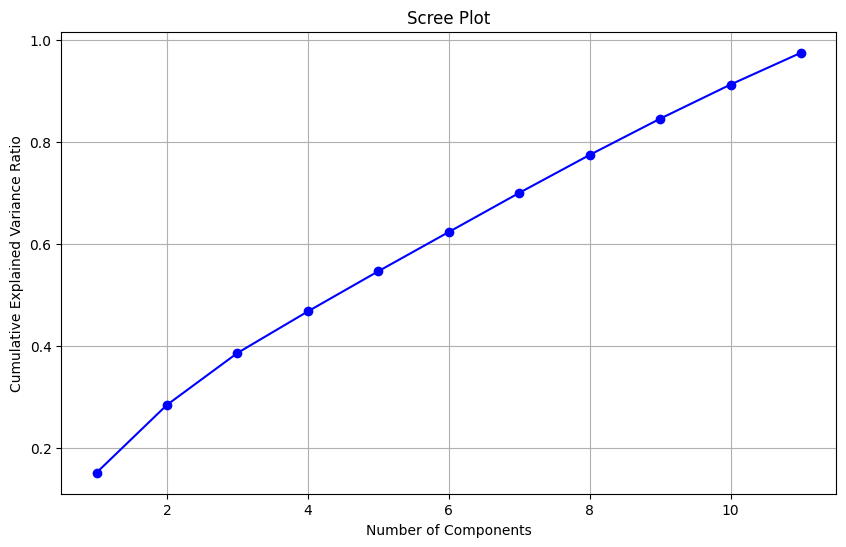

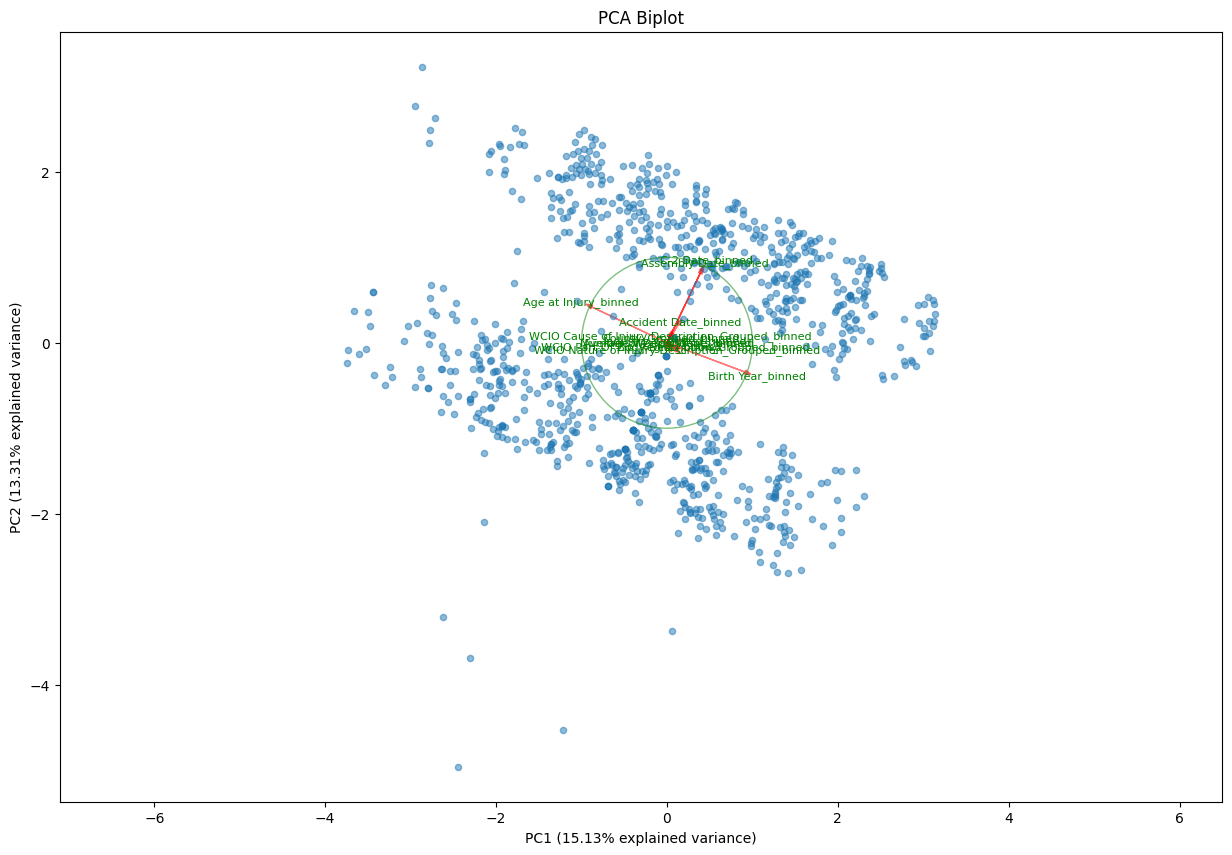


Principal Component Loadings:

Principal Component 1:
Birth Year_binned: 0.651
Age at Injury_binned: -0.627
C-2 Date_binned: 0.287
Assembly Date_binned: 0.278
Accident Date_binned: 0.096
WCIO Nature of Injury Description_Grouped_binned: 0.070
Industry_Grouped_binned: 0.066
WCIO Part Of Body Description_Grouped_binned: 0.062
County_Grouped_binned: 0.026
WCIO Cause of Injury Description_Grouped_binned: 0.023
Zip_Region_binned: 0.014
Average Weekly Wage_binned: 0.001
Number of Dependents_binned: -0.001

Principal Component 2:
C-2 Date_binned: 0.641
Assembly Date_binned: 0.618
Age at Injury_binned: 0.319
Birth Year_binned: -0.260
Accident Date_binned: 0.164
WCIO Cause of Injury Description_Grouped_binned: 0.057
WCIO Nature of Injury Description_Grouped_binned: -0.056
County_Grouped_binned: 0.041
WCIO Part Of Body Description_Grouped_binned: -0.031
Zip_Region_binned: -0.030
Industry_Grouped_binned: 0.015
Number of Dependents_binned: -0.004
Average Weekly Wage_binned: -0.001

Principal Comp

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

def prepare_and_scale_data(df, exclude_cols=['Claim Identifier', 'Claim Injury Type']):
    """
    Prepare and scale the data, excluding specified columns
    """
    # Create copy of dataframe and select features
    feature_names = [col for col in df.columns if col not in exclude_cols]
    X = df[feature_names].copy()

    print(f"\nPreparing data:")
    print(f"Original shape: {df.shape}")
    print(f"Features selected: {len(feature_names)}")

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Validate scaling
    scaled_df = pd.DataFrame(X_scaled, columns=feature_names)
    validation_results = pd.DataFrame({
        'Feature': feature_names,
        'Mean': scaled_df.mean(),
        'Std': scaled_df.std()
    })

    print("\nScaling Validation:")
    print(validation_results.round(6))

    return X_scaled, feature_names

def perform_pca_analysis(X, feature_names):
    # Initialize PCA with enough components to explain 95% variance
    pca = PCA(n_components=0.95)  # This tells PCA to keep enough components to explain 95% of variance
    principal_components = pca.fit_transform(X)

    # Create DataFrame with all retained principal components
    pca_df = pd.DataFrame(
        data=principal_components,
        columns=[f'PC{i+1}' for i in range(principal_components.shape[1])]
    )
    return pca_df, pca

def plot_pca_results(pca_df, pca, feature_names, save_path=None):
    """
    Create and save PCA visualization plots
    """
    if save_path:
        os.makedirs(save_path, exist_ok=True)

    # Scree plot
    plt.figure(figsize=(10, 6))
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumsum) + 1), cumsum, 'bo-')
    plt.grid(True)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Scree Plot')
    if save_path:
        plt.savefig(f'{save_path}/scree_plot.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Biplot
    plt.figure(figsize=(15, 10))
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

    # Plot loadings
    for i, feature in enumerate(feature_names):
        plt.arrow(0, 0, loadings[i, 0], loadings[i, 1],
                 color='r', alpha=0.5, head_width=0.05)
        plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15,
                feature, color='g', ha='center', va='center', fontsize=8)

    # Plot scatter points (random sample for better visualization)
    n_samples = min(1000, len(pca_df))
    sample_indices = np.random.choice(len(pca_df), n_samples, replace=False)
    plt.scatter(pca_df.iloc[sample_indices]['PC1'],
               pca_df.iloc[sample_indices]['PC2'],
               alpha=0.5, s=20)

    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)')
    plt.title('PCA Biplot')

    # Add a circle
    circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='g', alpha=0.5)
    plt.gca().add_patch(circle)
    plt.axis('equal')

    if save_path:
        plt.savefig(f'{save_path}/biplot.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Print component loadings
    print("\nPrincipal Component Loadings:")
    for i in range(pca.n_components_):
        print(f"\nPrincipal Component {i+1}:")
        loadings_dict = dict(zip(feature_names, pca.components_[i]))
        sorted_loadings = sorted(loadings_dict.items(), key=lambda x: abs(x[1]), reverse=True)
        for feature, loading in sorted_loadings:
            print(f"{feature}: {loading:.3f}")

# Run the complete analysis
print("Starting PCA analysis pipeline...")
X_scaled, feature_names = prepare_and_scale_data(encoded_df)
pca_df, pca = perform_pca_analysis(X_scaled, feature_names)
plot_pca_results(pca_df, pca, feature_names, save_path='plots')

# Print final shapes
print("\nFinal Data Shapes:")
print(f"Original features: {len(feature_names)}")
print(f"Principal components: {pca_df.shape[1]}")

# Comprehensive Principal Component Analysis
## Workers Compensation Claims Dataset

### Dataset Overview
- **Records**: 593,471
- **Original Features**: 13
- **Retained Principal Components**: 11
- **Data Preparation**: All features standardized (mean=0, std=1)

### Principal Components Analysis

#### PC1: Age-Timeline Component (≈15.1% variance)
**Theme: Demographic Age Profile**
- **Strong Positive**: Birth Year (0.651)
- **Strong Negative**: Age at Injury (-0.627)
- **Moderate**: Administrative dates (C-2: 0.287, Assembly: 0.278)
**Interpretation**: Represents the age structure of claims, contrasting younger workers (later birth years) with older workers. Administrative dates suggest possible age-related processing patterns.

#### PC2: Administrative Processing (≈13.3% variance)
**Theme: Claim Processing Timeline**
- **Strong Positive**:
  * C-2 Date (0.641)
  * Assembly Date (0.618)
- **Moderate**: Age factors (Age: 0.319, Birth Year: -0.260)
**Interpretation**: Captures administrative processing efficiency and timeline patterns, with some age-related influences.

#### PC3: Injury Characteristics (≈10.2% variance)
**Theme: Physical Injury Profile**
- **Strong Loadings**:
  * Body Part (0.573)
  * Cause of Injury (0.527)
  * Nature of Injury (0.486)
**Interpretation**: Describes patterns in how injuries occur and their physical manifestation.

#### PC4: Geographic-Industrial Pattern (≈8.2% variance)
**Theme: Location-Industry Relations**
- **Primary Factors**:
  * Industry (0.645)
  * Nature of Injury (0.425)
  * County (-0.405)
  * Zip Region (0.375)
**Interpretation**: Shows regional industry patterns and associated injury types.

#### PC5: Regional Timing (≈7% estimated)
**Theme: Geographic Temporal Patterns**
- **Key Loadings**:
  * Accident Date (0.599)
  * Zip Region (-0.570)
  * County (-0.436)
**Interpretation**: Reveals regional differences in accident timing and reporting.

#### PC6: Economic Profile (≈6% estimated)
**Theme: Financial Characteristics**
- **Dominant Factors**:
  * Average Weekly Wage (0.921)
  * Number of Dependents (-0.382)
**Interpretation**: Captures financial aspects of claims and family structure.

#### PC7: Family Structure (≈5% estimated)
**Theme: Dependent Relations**
- **Primary Loadings**:
  * Number of Dependents (0.898)
  * Average Weekly Wage (0.388)
**Interpretation**: Represents family size and associated income patterns.

#### PC8: Regional Processing (≈4% estimated)
**Theme: Geographic Processing**
- **Key Factors**:
  * Zip Region (0.700)
  * Accident Date (0.548)
  * Industry (-0.304)
**Interpretation**: Shows regional variations in claim processing times.

#### PC9: Local Industry Patterns (≈3% estimated)
**Theme: Local Business Patterns**
- **Main Loadings**:
  * County (0.642)
  * Industry (0.577)
  * Accident Date (0.427)
**Interpretation**: Represents local industry concentrations and accident patterns.

#### PC10: Injury Causation (≈2% estimated)
**Theme: Injury Mechanics**
- **Strong Factors**:
  * Cause of Injury (0.832)
  * Body Part (-0.451)
  * Nature of Injury (-0.249)
**Interpretation**: Detailed injury cause-effect relationships.

#### PC11: Injury Type Detail (≈1% estimated)
**Theme: Specific Injury Patterns**
- **Primary Components**:
  * Nature of Injury (0.675)
  * Body Part (-0.662)
  * Industry (-0.229)
**Interpretation**: Fine-grained injury type patterns.

### Key Insights

1. **Hierarchical Importance**
   - Age and administrative factors dominate (PC1 & PC2)
   - Injury characteristics form secondary patterns (PC3)
   - Geographic and industry factors create tertiary patterns (PC4 & PC5)
   - Economic and family factors are less dominant but distinct (PC6 & PC7)

2. **Regional Variations**
   - Geographic factors appear in multiple components (PC4, PC5, PC8, PC9)
   - Suggests strong regional differences in:
     * Industry distribution
     * Claim processing
     * Accident patterns
     * Economic factors

3. **Injury Patterns**
   - Multiple layers of injury characterization (PC3, PC10, PC11)
   - Strong relationships between:
     * Cause and body part
     * Nature of injury and industry
     * Regional injury patterns

4. **Administrative Efficiency**
   - Processing times form distinct patterns (PC2)
   - Regional variations in processing (PC8)
   - Age-related processing differences (PC1)

### Recommendations

1. **Process Optimization**
   - Target administrative efficiency improvements based on PC2 patterns
   - Address regional processing variations identified in PC8
   - Consider age-specific processing strategies

2. **Prevention Strategies**
   - Develop industry-specific safety programs (PC4, PC9)
   - Focus on region-specific risks (PC5, PC8)
   - Address age-related risk factors (PC1)

3. **Resource Allocation**
   - Distribute resources based on regional patterns (PC5, PC8, PC9)
   - Consider economic factors in program design (PC6)
   - Account for family structure impacts (PC7)

4. **Training and Education**
   - Design industry-specific training programs (PC4, PC9)
   - Develop age-appropriate safety materials (PC1)
   - Create region-specific guidance (PC5, PC8)

### Conclusion
The analysis reveals a complex interplay of demographic, administrative, geographic, and injury-related factors in workers' compensation claims. The retention of 11 principal components suggests that while there are clear primary patterns, the system's complexity requires multiple dimensions for comprehensive understanding.

Generating advanced PCA report...


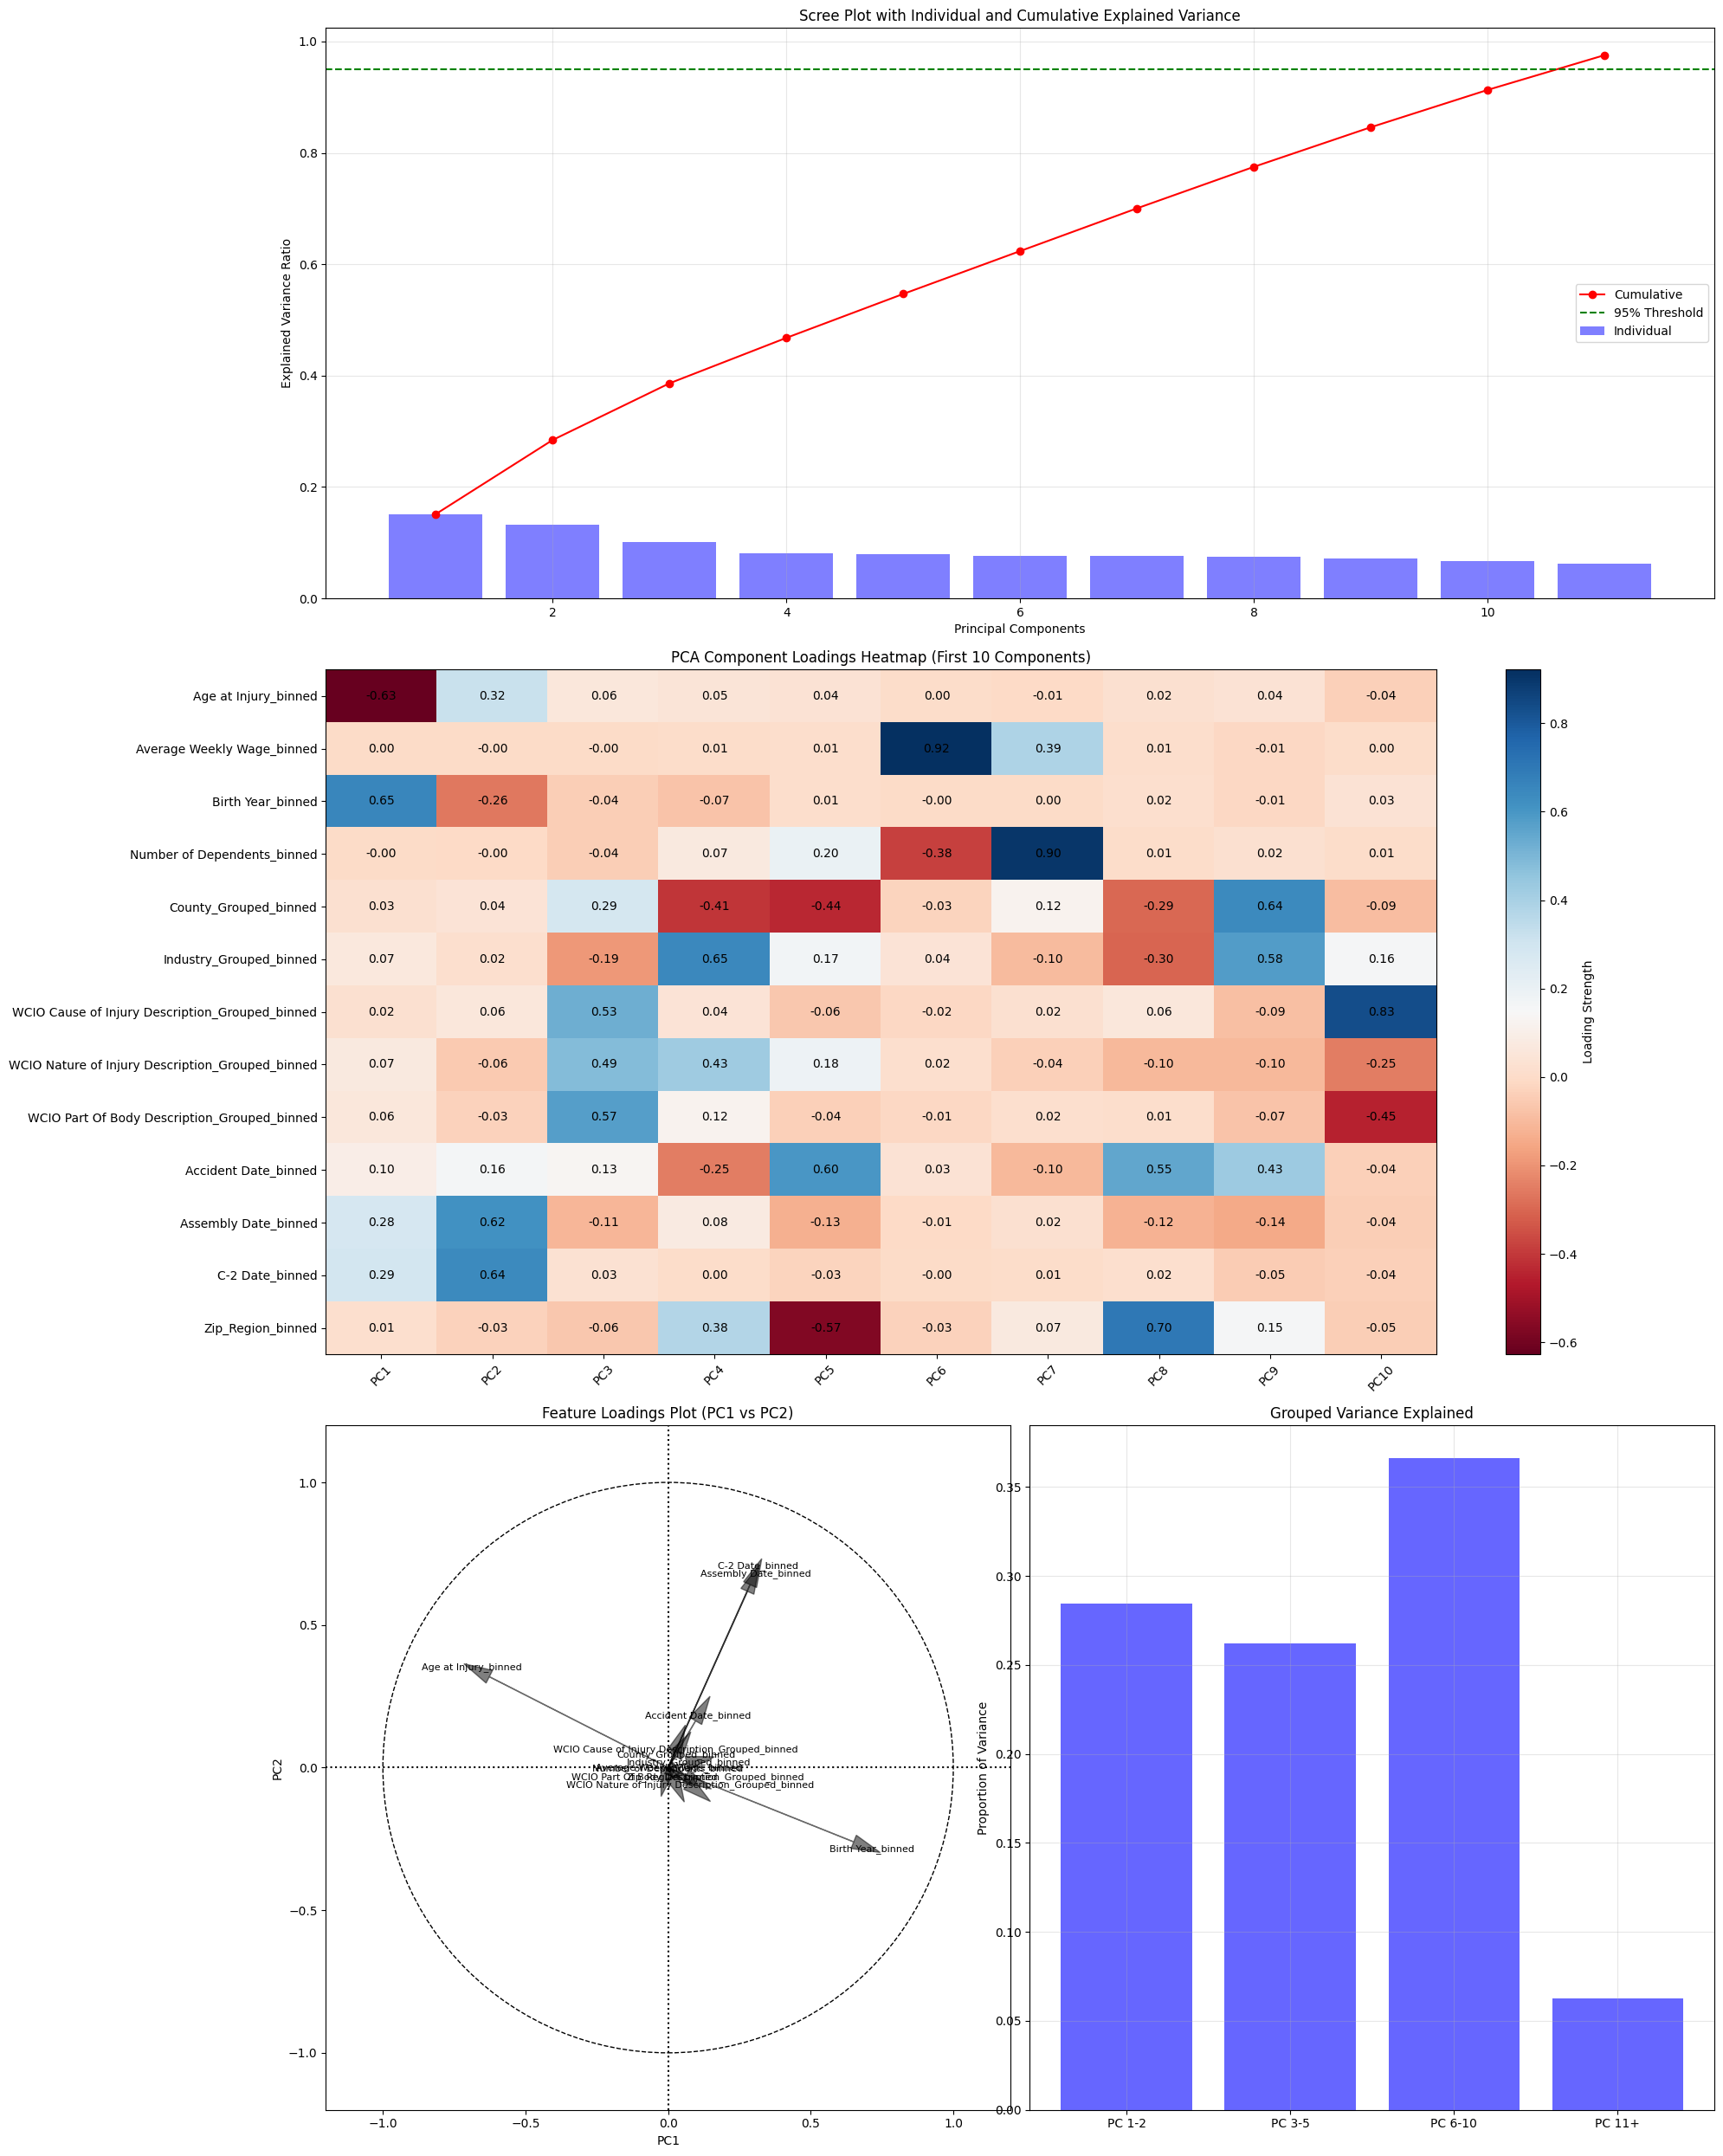


COMPREHENSIVE PCA ANALYSIS REPORT

1. VARIANCE EXPLANATION
----------------------------------------
PC 1:  0.151 ( 15.1%) - Cumulative:  0.151 ( 15.1%)
PC 2:  0.133 ( 13.3%) - Cumulative:  0.284 ( 28.4%)
PC 3:  0.102 ( 10.2%) - Cumulative:  0.386 ( 38.6%)
PC 4:  0.082 (  8.2%) - Cumulative:  0.468 ( 46.8%)
PC 5:  0.079 (  7.9%) - Cumulative:  0.547 ( 54.7%)
PC 6:  0.077 (  7.7%) - Cumulative:  0.624 ( 62.4%)
PC 7:  0.077 (  7.7%) - Cumulative:  0.700 ( 70.0%)
PC 8:  0.074 (  7.4%) - Cumulative:  0.775 ( 77.5%)
PC 9:  0.071 (  7.1%) - Cumulative:  0.846 ( 84.6%)
PC10:  0.067 (  6.7%) - Cumulative:  0.913 ( 91.3%)

2. COMPONENT SIGNIFICANCE
----------------------------------------
Components with >5% variance explained: 11
Components needed for 95% variance: 11

3. TOP FEATURE CONTRIBUTIONS
----------------------------------------

Principal Component 1:
Birth Year_binned                       :    0.651
Age at Injury_binned                    :   -0.627
C-2 Date_binned                 

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import os

def create_custom_heatmap(data, ax, title):
    """
    Create a custom heatmap without seaborn dependency
    """
    im = ax.imshow(data, cmap='RdBu', aspect='auto')
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels([f'PC{i+1}' for i in range(data.shape[1])])
    ax.set_yticklabels(data.index)

    plt.colorbar(im, ax=ax, label='Loading Strength')

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = ax.text(j, i, f'{data.iloc[i, j]:.2f}',
                         ha="center", va="center", color="black")

    ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.setp(ax.get_yticklabels(), rotation=0)

def create_loading_plot(pca_components, feature_names, ax):
    """
    Create feature loading plot for first two principal components
    """
    loadings_pc1 = pca_components[0]
    loadings_pc2 = pca_components[1]

    # Scale down text size if there are many features
    text_size = min(8, 160 / len(feature_names))

    for i, (x, y) in enumerate(zip(loadings_pc1, loadings_pc2)):
        ax.arrow(0, 0, x, y, head_width=0.05, head_length=0.1, fc='black', ec='black', alpha=0.5)
        ax.text(x*1.1, y*1.1, feature_names[i], ha='center', va='center', fontsize=text_size)

    circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='black', ls='--')
    ax.add_patch(circle)
    ax.axhline(y=0, color='black', ls=':')
    ax.axvline(x=0, color='black', ls=':')
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.set_title('Feature Loadings Plot (PC1 vs PC2)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

def create_advanced_pca_report(X_scaled, feature_names, pca, save_path='pca_report'):
    """
    Create comprehensive PCA analysis report with advanced visualizations
    """
    os.makedirs(save_path, exist_ok=True)

    # Create figure with subplot grid
    fig = plt.figure(figsize=(20, 25))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1.2, 1.2])

    # 1. Scree Plot with Cumulative Variance
    ax1 = fig.add_subplot(gs[0, :])
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    individual = pca.explained_variance_ratio_

    ax1.bar(range(1, len(individual) + 1), individual, alpha=0.5, color='blue', label='Individual')
    ax1.plot(range(1, len(cumsum) + 1), cumsum, 'r-o', label='Cumulative')
    ax1.axhline(y=0.95, color='green', linestyle='--', label='95% Threshold')
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Scree Plot with Individual and Cumulative Explained Variance')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Custom Heatmap of Component Loadings
    ax2 = fig.add_subplot(gs[1, :])
    n_components = min(10, len(pca.components_))
    loadings = pd.DataFrame(
        pca.components_[:n_components].T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=feature_names
    )
    create_custom_heatmap(loadings, ax2, 'PCA Component Loadings Heatmap (First 10 Components)')

    # 3. Feature Loading Plot and Variance Groups
    ax3 = fig.add_subplot(gs[2, 0])
    create_loading_plot(pca.components_, feature_names, ax3)

    # 4. Variance Explained by Groups
    ax4 = fig.add_subplot(gs[2, 1])
    variance_exp = pd.Series(pca.explained_variance_ratio_)
    grouped_variance = [
        variance_exp[:2].sum(),
        variance_exp[2:5].sum(),
        variance_exp[5:10].sum(),
        variance_exp[10:].sum() if len(variance_exp) > 10 else 0
    ]
    ax4.bar(['PC 1-2', 'PC 3-5', 'PC 6-10', 'PC 11+'], grouped_variance, color='blue', alpha=0.6)
    ax4.set_title('Grouped Variance Explained')
    ax4.set_ylabel('Proportion of Variance')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{save_path}/pca_report.png', bbox_inches='tight', dpi=300)
    plt.show()

    # Print detailed statistical report
    print("\n" + "="*80)
    print("COMPREHENSIVE PCA ANALYSIS REPORT")
    print("="*80)

    print("\n1. VARIANCE EXPLANATION")
    print("-"*40)
    cumulative = 0
    for i, ratio in enumerate(pca.explained_variance_ratio_[:10], 1):
        cumulative += ratio
        print(f"PC{i:2d}: {ratio:6.3f} ({ratio*100:5.1f}%) - Cumulative: {cumulative:6.3f} ({cumulative*100:5.1f}%)")

    print("\n2. COMPONENT SIGNIFICANCE")
    print("-"*40)
    n_significant = sum(pca.explained_variance_ratio_ > 0.05)
    n_95 = np.where(cumsum >= 0.95)[0][0] + 1
    print(f"Components with >5% variance explained: {n_significant}")
    print(f"Components needed for 95% variance: {n_95}")

    print("\n3. TOP FEATURE CONTRIBUTIONS")
    print("-"*40)
    for i in range(3):
        print(f"\nPrincipal Component {i+1}:")
        loadings = dict(zip(feature_names, pca.components_[i]))
        sorted_loadings = sorted(loadings.items(), key=lambda x: abs(x[1]), reverse=True)
        for feature, loading in sorted_loadings[:5]:
            print(f"{feature:40s}: {loading:8.3f}")

    # Save report to file
    with open(f'{save_path}/pca_report.txt', 'w') as f:
        f.write("PCA ANALYSIS SUMMARY\n\n")
        f.write(f"Features analyzed: {len(feature_names)}\n")
        f.write(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}\n")
        f.write(f"Components needed for 95% variance: {n_95}\n\n")
        f.write("Top 3 Principal Components Variance:\n")
        for i in range(3):
            f.write(f"PC{i+1}: {pca.explained_variance_ratio_[i]:.2%}\n")

        f.write("\nTop Feature Contributions:\n")
        for i in range(3):
            f.write(f"\nPrincipal Component {i+1}:\n")
            loadings = dict(zip(feature_names, pca.components_[i]))
            sorted_loadings = sorted(loadings.items(), key=lambda x: abs(x[1]), reverse=True)
            for feature, loading in sorted_loadings[:5]:
                f.write(f"{feature:40s}: {loading:8.3f}\n")

# Run the analysis
print("Generating advanced PCA report...")
advanced_pca_report = create_advanced_pca_report(X_scaled, feature_names, pca)

In [85]:
!pip install umap-learn


Processing demographic features...
Running UMAP...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


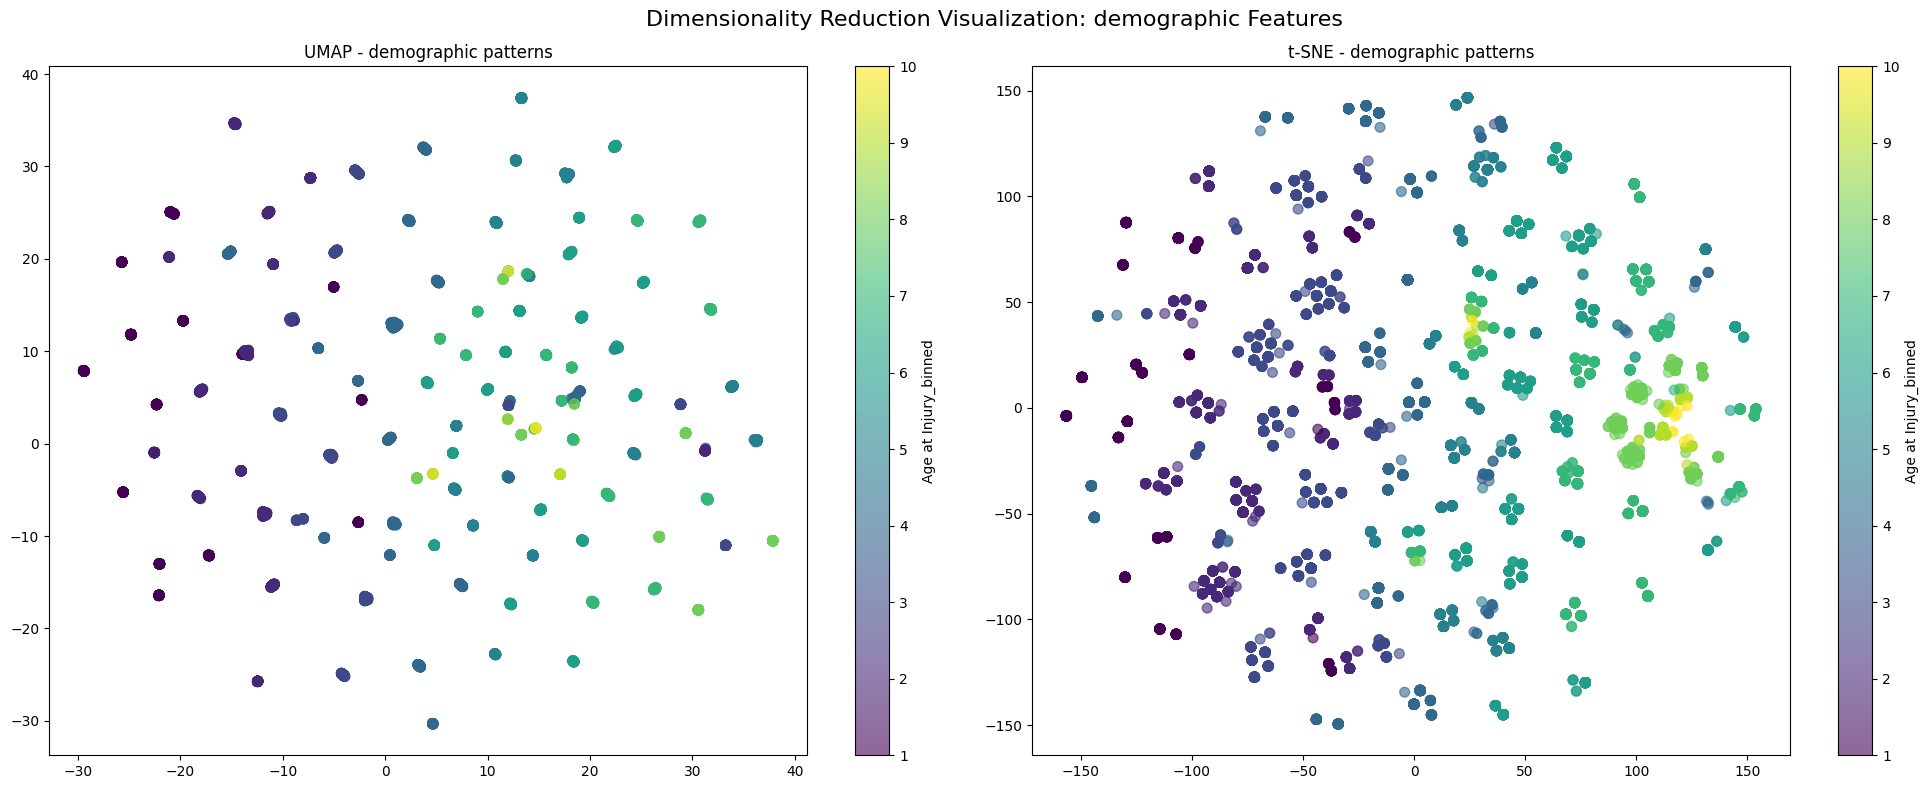


Processing administrative features...
Running UMAP...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


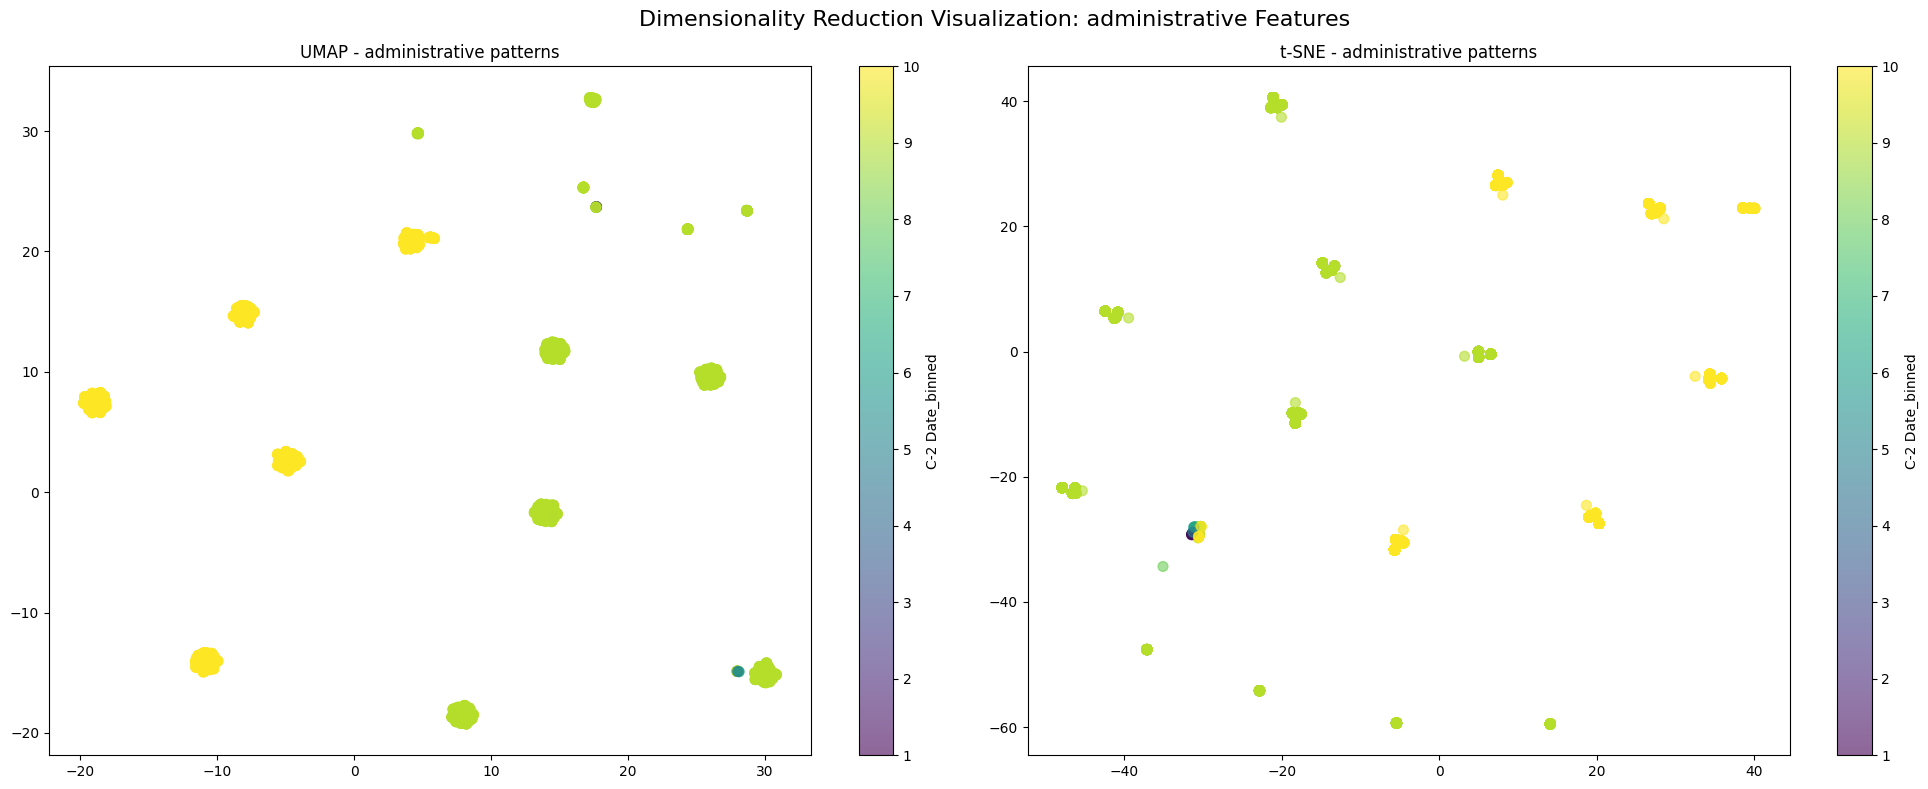


Processing injury_profile features...
Running UMAP...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


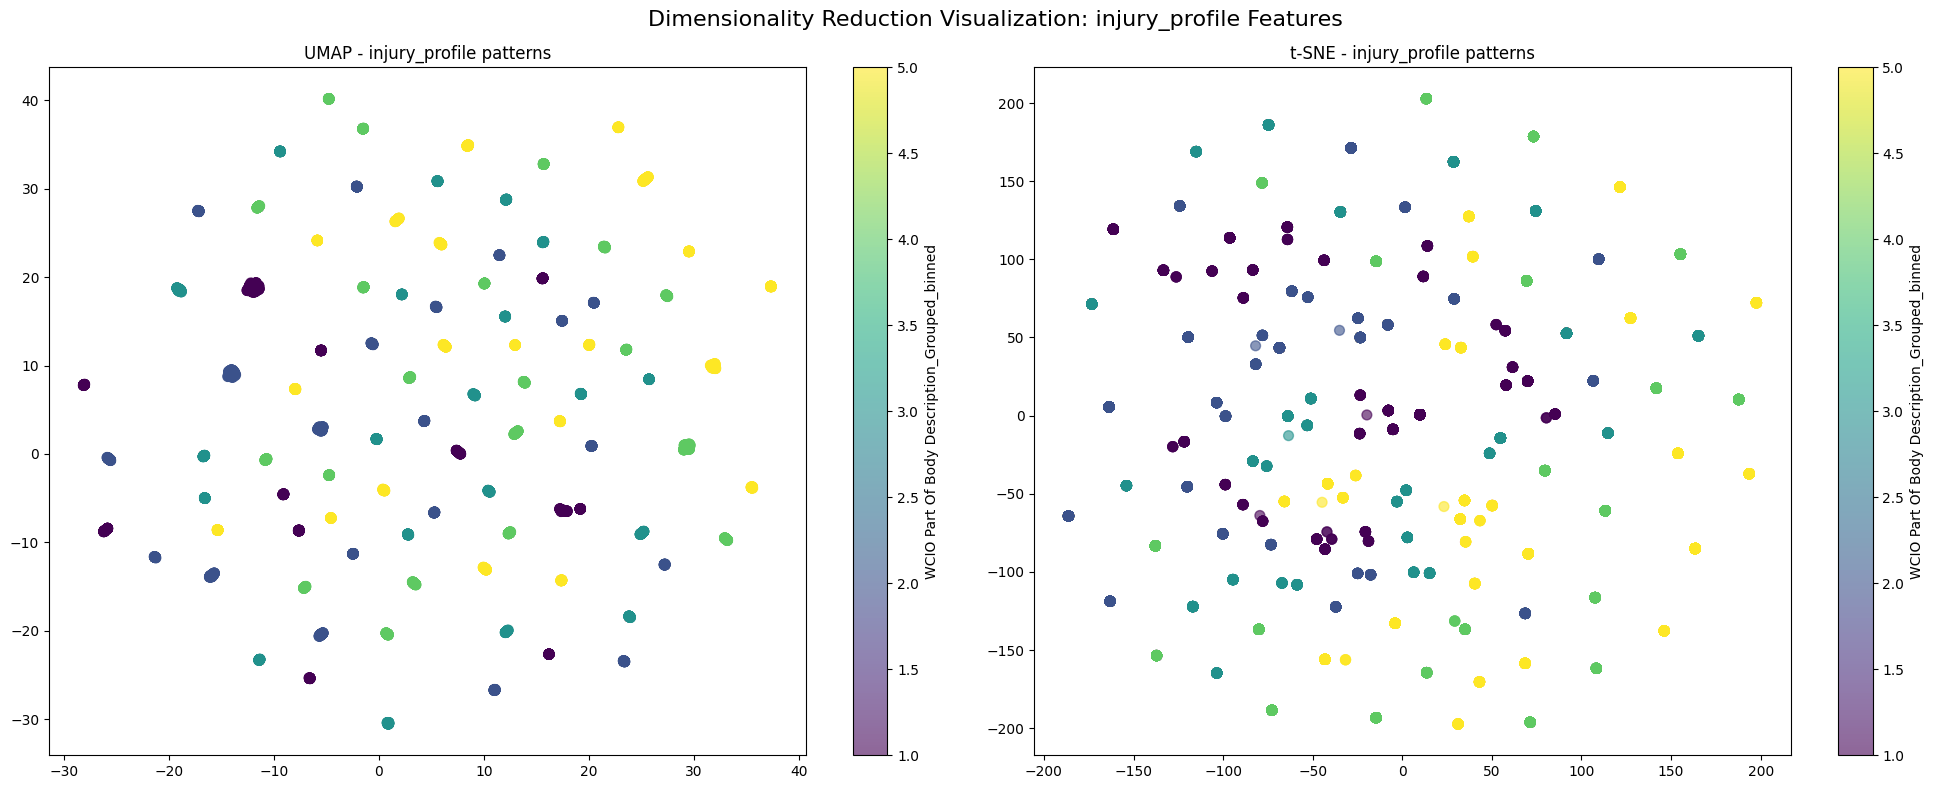


Processing geographic features...
Running UMAP...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


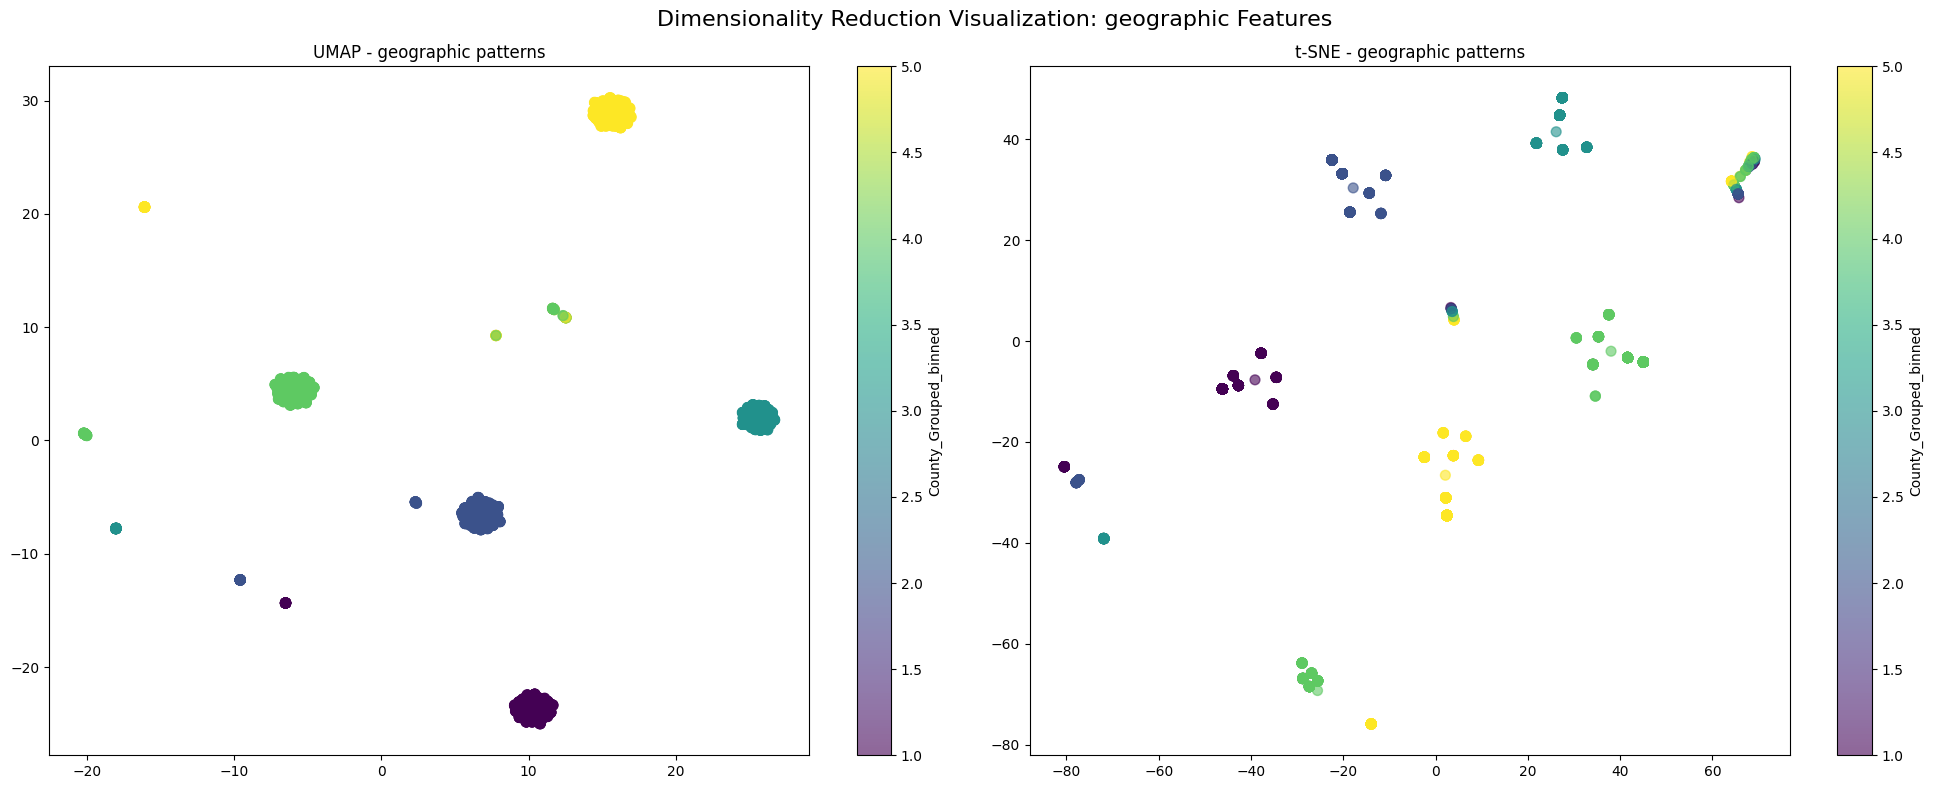


Processing economic features...
Running UMAP...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


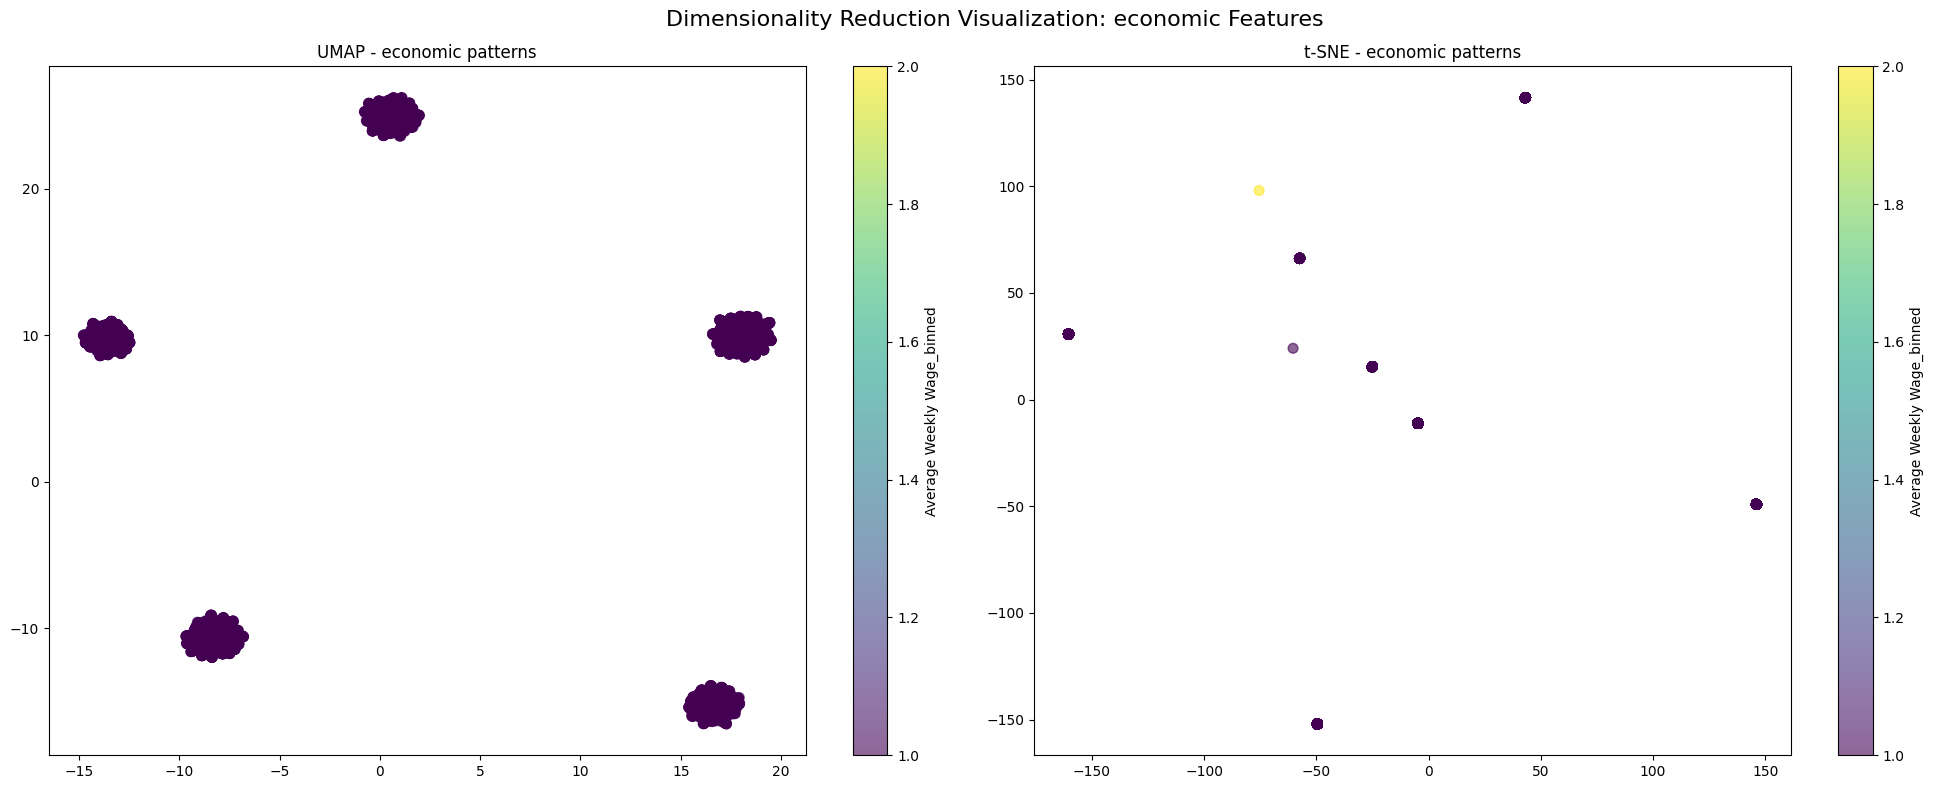


Feature Groups Analysis:

DEMOGRAPHIC features:
- Age at Injury_binned
- Birth Year_binned
- Number of Dependents_binned

ADMINISTRATIVE features:
- C-2 Date_binned
- Assembly Date_binned
- Accident Date_binned

INJURY_PROFILE features:
- WCIO Part Of Body Description_Grouped_binned
- WCIO Cause of Injury Description_Grouped_binned
- WCIO Nature of Injury Description_Grouped_binned

GEOGRAPHIC features:
- County_Grouped_binned
- Zip_Region_binned

ECONOMIC features:
- Average Weekly Wage_binned
- Industry_Grouped_binned


In [86]:
import umap
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def create_feature_groups(df):
    """
    Create feature groups based on PCA analysis insights
    """
    feature_groups = {
        'demographic': [
            'Age at Injury_binned',
            'Birth Year_binned',
            'Number of Dependents_binned'
        ],
        'administrative': [
            'C-2 Date_binned',
            'Assembly Date_binned',
            'Accident Date_binned'
        ],
        'injury_profile': [
            'WCIO Part Of Body Description_Grouped_binned',
            'WCIO Cause of Injury Description_Grouped_binned',
            'WCIO Nature of Injury Description_Grouped_binned'
        ],
        'geographic': [
            'County_Grouped_binned',
            'Zip_Region_binned'
        ],
        'economic': [
            'Average Weekly Wage_binned',
            'Industry_Grouped_binned'
        ]
    }

    # Verify features exist in dataframe
    for group in feature_groups:
        feature_groups[group] = [f for f in feature_groups[group] if f in df.columns]

    return feature_groups

def visualize_patterns(df, feature_groups, n_samples=10000, random_state=42):
    """
    Create UMAP and t-SNE visualizations for different feature groups
    """
    # Sample data if needed
    if len(df) > n_samples:
        df = df.sample(n_samples, random_state=random_state)

    # Standardize the data
    scaler = StandardScaler()

    # UMAP and t-SNE parameters
    umap_params = {
        'n_neighbors': 30,     # Increased for better global structure
        'min_dist': 0.1,
        'n_components': 2,
        'random_state': random_state
    }

    tsne_params = {
        'n_components': 2,
        'perplexity': 50,      # Increased for better cluster separation
        'n_iter': 1000,
        'random_state': random_state
    }

    # Create visualizations for each feature group
    for group_name, features in feature_groups.items():
        if not features:
            print(f"No features found for {group_name}")
            continue

        print(f"\nProcessing {group_name} features...")

        # Prepare data for this group
        X = df[features].copy()
        X_scaled = scaler.fit_transform(X)

        # Create figure
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))

        # Run and plot UMAP
        print("Running UMAP...")
        umap_embed = umap.UMAP(**umap_params).fit_transform(X_scaled)

        # Color by the first feature in the group
        color_feature = features[0]

        # UMAP plot
        scatter1 = axes[0].scatter(
            umap_embed[:, 0],
            umap_embed[:, 1],
            c=df[color_feature],
            cmap='viridis',
            alpha=0.6,
            s=50
        )
        axes[0].set_title(f'UMAP - {group_name} patterns')
        plt.colorbar(scatter1, ax=axes[0], label=color_feature)

        # Run and plot t-SNE
        print("Running t-SNE...")
        tsne_embed = TSNE(**tsne_params).fit_transform(X_scaled)

        # t-SNE plot
        scatter2 = axes[1].scatter(
            tsne_embed[:, 0],
            tsne_embed[:, 1],
            c=df[color_feature],
            cmap='viridis',
            alpha=0.6,
            s=50
        )
        axes[1].set_title(f't-SNE - {group_name} patterns')
        plt.colorbar(scatter2, ax=axes[1], label=color_feature)

        plt.suptitle(f'Dimensionality Reduction Visualization: {group_name} Features', fontsize=16)
        plt.tight_layout()
        plt.show()

def analyze_clusters(df, embeddings, feature_groups, group_name):
    """
    Analyze the relationships between clusters and features
    """
    from sklearn.cluster import DBSCAN

    # Perform clustering on the embeddings
    clusterer = DBSCAN(eps=0.5, min_samples=5)
    clusters = clusterer.fit_predict(embeddings)

    # Create analysis DataFrame
    cluster_stats = pd.DataFrame()
    features = feature_groups[group_name]

    for feature in features:
        cluster_means = pd.DataFrame(df.groupby(clusters)[feature].mean())
        cluster_stats[f'{feature}_mean'] = cluster_means[feature]

    return cluster_stats

# Main execution
def run_visualization_analysis(df):
    """
    Run the complete visualization and analysis pipeline
    """
    # Create feature groups
    feature_groups = create_feature_groups(df)

    # Run visualizations
    visualize_patterns(df, feature_groups)

    # Print summary of feature groups
    print("\nFeature Groups Analysis:")
    for group, features in feature_groups.items():
        print(f"\n{group.upper()} features:")
        for feature in features:
            print(f"- {feature}")

# Example usage:
run_visualization_analysis(encoded_df)

In [ ]:
import numpy as np
import pandas as pd
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Assuming your preprocessed data is in 'processed_data'
# and categorical columns are already encoded

def create_visualizations(df, target_column='Claim Injury Type'):
    # Remove target and standardize
    X = df.drop(columns=[target_column])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # UMAP
    print("Performing UMAP...")
    umap_2d = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric='euclidean',
        random_state=42
    )
    umap_result = umap_2d.fit_transform(X_scaled)

    # t-SNE
    print("Performing t-SNE...")
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        n_iter=1000,
        random_state=42
    )
    tsne_result = tsne.fit_transform(X_scaled)

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Color by District (geographic pattern)
    district_colors = df['District Name'] if 'District Name' in df.columns else None

    # UMAP plot
    scatter1 = ax1.scatter(
        umap_result[:, 0],
        umap_result[:, 1],
        c=district_colors.astype('category').cat.codes if district_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax1.set_title('UMAP Projection')
    if district_colors is not None:
        plt.colorbar(scatter1, ax=ax1, label='District')

    # t-SNE plot
    scatter2 = ax2.scatter(
        tsne_result[:, 0],
        tsne_result[:, 1],
        c=district_colors.astype('category').cat.codes if district_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax2.set_title('t-SNE Projection')
    if district_colors is not None:
        plt.colorbar(scatter2, ax=ax2, label='District')

    plt.tight_layout()
    plt.show()

    # Additional visualizations for temporal patterns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Color by time (if available)
    time_colors = pd.to_datetime(df['Accident Date']).dt.year if 'Accident Date' in df.columns else None

    # UMAP plot - temporal
    scatter1 = ax1.scatter(
        umap_result[:, 0],
        umap_result[:, 1],
        c=time_colors if time_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax1.set_title('UMAP - Temporal Patterns')
    if time_colors is not None:
        plt.colorbar(scatter1, ax=ax1, label='Year')

    # t-SNE plot - temporal
    scatter2 = ax2.scatter(
        tsne_result[:, 0],
        tsne_result[:, 1],
        c=time_colors if time_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax2.set_title('t-SNE - Temporal Patterns')
    if time_colors is not None:
        plt.colorbar(scatter2, ax=ax2, label='Year')

    plt.tight_layout()
    plt.show()

    # Visualization for injury patterns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Color by injury type
    injury_colors = df['WCIO Part Of Body Description'] if 'WCIO Part Of Body Description' in df.columns else None

    # UMAP plot - injury
    scatter1 = ax1.scatter(
        umap_result[:, 0],
        umap_result[:, 1],
        c=injury_colors.astype('category').cat.codes if injury_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax1.set_title('UMAP - Injury Patterns')
    if injury_colors is not None:
        plt.colorbar(scatter1, ax=ax1, label='Body Part')

    # t-SNE plot - injury
    scatter2 = ax2.scatter(
        tsne_result[:, 0],
        tsne_result[:, 1],
        c=injury_colors.astype('category').cat.codes if injury_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax2.set_title('t-SNE - Injury Patterns')
    if injury_colors is not None:
        plt.colorbar(scatter2, ax=ax2, label='Body Part')

    plt.tight_layout()
    plt.show()

    return umap_result, tsne_result

# Execute
umap_result, tsne_result = create_visualizations(processed_data)

# Optional: Save results
np.save('umap_embedding.npy', umap_result)
np.save('tsne_embedding.npy', tsne_result)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import umap
from sklearn.manifold import TSNE

def run_dimensionality_reduction(data, feature_groups):
    """
    Run UMAP and t-SNE for each feature group and store results
    """
    umap_results = {}
    tsne_results = {}

    # UMAP parameters
    umap_params = {
        'n_neighbors': 15,
        'min_dist': 0.1,
        'n_components': 2,
        'random_state': 42
    }

    # t-SNE parameters
    tsne_params = {
        'n_components': 2,
        'perplexity': 30,
        'max_iter': 1000,
        'random_state': 42
    }

    for group_name, features in feature_groups.items():
        print(f"\nProcessing {group_name} features...")

        # Get available features
        available_features = [f for f in features if f in data.columns]
        if not available_features:
            print(f"No features found for {group_name}")
            continue

        subset_data = data[available_features]

        # Run UMAP
        print("Running UMAP...")
        umap_results[group_name] = umap.UMAP(**umap_params).fit_transform(subset_data)

        # Run t-SNE
        print("Running t-SNE...")
        tsne_results[group_name] = TSNE(**tsne_params).fit_transform(subset_data)

    return umap_results, tsne_results

def analyze_embeddings(embeddings, labels, group_name, original_data):
    """
    Comprehensive analysis of embedding quality and cluster separation
    """
    results = {}

    # Clustering Quality Metrics
    try:
        results['silhouette'] = silhouette_score(embeddings, labels)
        results['calinski'] = calinski_harabasz_score(embeddings, labels)
        results['davies'] = davies_bouldin_score(embeddings, labels)
    except Exception as e:
        print(f"Warning: Clustering metrics failed for {group_name}: {str(e)}")
        results['silhouette'] = np.nan
        results['calinski'] = np.nan
        results['davies'] = np.nan

    # Distribution Analysis
    feature_stats = {
        'mean': np.mean(embeddings, axis=0),
        'std': np.std(embeddings, axis=0),
        'skew': pd.DataFrame(embeddings).skew().values,
        'kurtosis': pd.DataFrame(embeddings).kurtosis().values
    }
    results['distribution'] = feature_stats

    return results

def generate_analysis_report(processed_data, umap_results, tsne_results, feature_groups):
    """
    Generate comprehensive analysis report
    """
    print("\n" + "="*50)
    print("EMBEDDING ANALYSIS REPORT")
    print("="*50)

    for group_name, features in feature_groups.items():
        print(f"\n{group_name.upper()} ANALYSIS:")
        print("-"*30)

        # Get relevant data
        available_features = [f for f in features if f in processed_data.columns]
        if not available_features:
            print(f"No features found for {group_name}")
            continue

        subset_data = processed_data[available_features]

        # Get primary label for this group
        primary_label = available_features[0]
        labels = processed_data[primary_label]

        if group_name in umap_results and group_name in tsne_results:
            # Analyze UMAP results
            umap_analysis = analyze_embeddings(
                umap_results[group_name],
                labels,
                group_name,
                subset_data
            )

            # Analyze t-SNE results
            tsne_analysis = analyze_embeddings(
                tsne_results[group_name],
                labels,
                group_name,
                subset_data
            )

            # Print Results
            print("\nUMAP Analysis:")
            print(f"Silhouette Score: {umap_analysis['silhouette']:.3f}")
            print(f"Calinski-Harabasz Score: {umap_analysis['calinski']:.3f}")
            print(f"Davies-Bouldin Score: {umap_analysis['davies']:.3f}")

            print("\nt-SNE Analysis:")
            print(f"Silhouette Score: {tsne_analysis['silhouette']:.3f}")
            print(f"Calinski-Harabasz Score: {tsne_analysis['calinski']:.3f}")
            print(f"Davies-Bouldin Score: {tsne_analysis['davies']:.3f}")

        # Feature Importance Analysis
        print("\nFeature Importance Analysis:")
        feature_importance = analyze_feature_importance(subset_data)
        print(feature_importance.to_string())

        # Distribution Analysis
        print("\nDistribution Characteristics:")
        plot_distribution_analysis(subset_data, group_name)

# Run the complete analysis
# First, run dimensionality reduction
umap_results, tsne_results = run_dimensionality_reduction(processed_data, feature_groups)

# Then generate the report
generate_analysis_report(processed_data, umap_results, tsne_results, feature_groups)

# Additional Stability Analysis
print("\nCLUSTER STABILITY ANALYSIS")
print("="*30)
for group_name in feature_groups:
    if group_name in umap_results:
        stability = cluster_stability_analysis(
            umap_results[group_name],
            processed_data[feature_groups[group_name][0]]
        )
        print(f"\n{group_name} Stability:")
        print(f"Mean Score: {stability['mean']:.3f} ± {stability['std']:.3f}")
        print(f"95% CI: [{stability['ci_lower']:.3f}, {stability['ci_upper']:.3f}]")